In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from tensorflow import keras
from tensorflow.keras import layers
import time

In [ ]:
def load_data(data_root):

  X_train=[]
  Y_train=[]
  #Getting the list of images in the file
  X_images = os.listdir(data_root+"/Training_Images")
  Y_images = os.listdir(data_root+"/Ground_Truth")
  X_images.sort()
  Y_images.sort()
  print(X_images)
  print(Y_images)
  for i in range(len(X_images)):
    X_image=X_images[i]
    Y_image=Y_images[i]
    im=cv2.imread(data_root+"/Training_Images/"+X_image)
    im=cv2.resize(im,(128,128))
    im = np.asarray(im)
    im = (im.astype(np.float32)-127.5)/127.5
    X_train.append(im)
    im=cv2.imread(data_root+"/Ground_Truth/"+Y_image, cv2.IMREAD_UNCHANGED)
    im=cv2.resize(im,(128,128))
    im = np.asarray(im)
    im = im.astype(np.float32)/255
    Y_train.append(im)
  X_train = np.array(X_train)
  Y_train = np.array(Y_train)
  print(X_train.shape,Y_train.shape)
  return(X_train,Y_train)

In [ ]:
data_root="/content/gdrive/My Drive/Human_Segmentation/Dataset"
X_train,Y_train=load_data(data_root)

['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg', '108.jpg', '109.jpg', '11.jpg', '110.jpg', '111.jpg', '112.jpg', '113.jpg', '114.jpg', '115.jpg', '116.jpg', '117.jpg', '118.jpg', '119.jpg', '12.jpg', '120.jpg', '121.jpg', '122.jpg', '123.jpg', '124.jpg', '125.jpg', '126.jpg', '127.jpg', '128.jpg', '129.jpg', '13.jpg', '130.jpg', '131.jpg', '132.jpg', '133.jpg', '134.jpg', '135.jpg', '136.jpg', '137.jpg', '138.jpg', '139.jpg', '14.jpg', '140.jpg', '141.jpg', '142.jpg', '143.jpg', '144.jpg', '145.jpg', '146.jpg', '147.jpg', '148.jpg', '149.jpg', '15.jpg', '150.jpg', '151.jpg', '152.jpg', '153.jpg', '154.jpg', '155.jpg', '156.jpg', '157.jpg', '158.jpg', '159.jpg', '16.jpg', '160.jpg', '161.jpg', '162.jpg', '163.jpg', '164.jpg', '165.jpg', '166.jpg', '167.jpg', '168.jpg', '169.jpg', '17.jpg', '170.jpg', '171.jpg', '172.jpg', '173.jpg', '174.jpg', '175.jpg', '176.jpg', '177.jpg', '178.jpg', '179.jpg', '18.jpg', '180.jpg', '181.jpg'

In [ ]:

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=2):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=1, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=2):
    concat = keras.layers.Concatenate()([x, skip])
    c = keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding=padding, activation="relu")(concat)
    c = keras.layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, activation="relu")(c)
    #c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    #c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c  
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((128,128, 3))
    
    c0 = inputs
    c1 = down_block(c0, f[0]) #128 -> 64
    c2 = down_block(c1, f[1]) #64 -> 32
    c3 = down_block(c2, f[2]) #32 -> 16
    c4 = down_block(c3, f[3]) #16->8
    
    bn = bottleneck(c4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
def model_():
  model = UNet()
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
  #model.summary()
  return(model)

In [ ]:
def train_model(data,mask,n_epochs,batch_size,weights,checkpoint):
 model = model_()
 if weights!=0:
   #Loading previous trained models
		model.load_weights(checkpoint_dir+'/mask_'+str(weights)+'.h5')
 n_batches=int(data.shape[0]/batch_size)
 #print(n_batches)

 for epoch in range(n_epochs):
   print("Epoch : {}/{}".format(epoch+1+weights, n_epochs+weights))

   for i in range(n_batches):
     model.trainable = True
     loss = model.train_on_batch(data,mask)
     model.trainable = False
     print("Model Loss(Batch: {}): {}".format(i,loss))
     #generate_and_save_images(generator, epoch)
   if (epoch+1)%10==0:
     generate_and_save_images(model, epoch+weights,X_train[1])
     #display and save output image for every 100 epoch
     model.save_weights(checkpoint_dir+'/mask_'+str(epoch+1+weights)+'.h5',True)

In [ ]:
def generate_and_save_images(model, epoch,input):
  input=input.reshape((1,128,128,3))
  #print(input.shape)
  output=model.predict(input)
  output=output[0]*255
  cv2_imshow(output)
  cv2.imwrite("/content/gdrive/My Drive/Human_Segmentation/output/img_"+str(epoch+1)+".jpg",output)


Epoch : 1001/2000
Model Loss(Batch: 0): [0.018569640815258026, 0.9872344136238098]
Epoch : 1002/2000
Model Loss(Batch: 0): [4.495793342590332, 0.5794761776924133]
Epoch : 1003/2000
Model Loss(Batch: 0): [0.741771936416626, 0.8814796209335327]
Epoch : 1004/2000
Model Loss(Batch: 0): [1.0614948272705078, 0.873119056224823]
Epoch : 1005/2000
Model Loss(Batch: 0): [0.8315975666046143, 0.8762983679771423]
Epoch : 1006/2000
Model Loss(Batch: 0): [0.5465506911277771, 0.8845115900039673]
Epoch : 1007/2000
Model Loss(Batch: 0): [0.42779430747032166, 0.864242672920227]
Epoch : 1008/2000
Model Loss(Batch: 0): [0.41034260392189026, 0.8301277756690979]
Epoch : 1009/2000
Model Loss(Batch: 0): [0.4227929413318634, 0.8031782507896423]
Epoch : 1010/2000
Model Loss(Batch: 0): [0.41800156235694885, 0.7965887784957886]


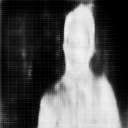

Epoch : 1011/2000
Model Loss(Batch: 0): [0.39147672057151794, 0.8113161325454712]
Epoch : 1012/2000
Model Loss(Batch: 0): [0.36139994859695435, 0.8352400064468384]
Epoch : 1013/2000
Model Loss(Batch: 0): [0.34992870688438416, 0.8482502102851868]
Epoch : 1014/2000
Model Loss(Batch: 0): [0.36061030626296997, 0.843132495880127]
Epoch : 1015/2000
Model Loss(Batch: 0): [0.3664691746234894, 0.838161051273346]
Epoch : 1016/2000
Model Loss(Batch: 0): [0.352931410074234, 0.845550537109375]
Epoch : 1017/2000
Model Loss(Batch: 0): [0.3349531590938568, 0.8576502203941345]
Epoch : 1018/2000
Model Loss(Batch: 0): [0.3223293423652649, 0.866694986820221]
Epoch : 1019/2000
Model Loss(Batch: 0): [0.3136551082134247, 0.8719581365585327]
Epoch : 1020/2000
Model Loss(Batch: 0): [0.3056516647338867, 0.8745774030685425]


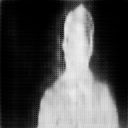

Epoch : 1021/2000
Model Loss(Batch: 0): [0.29727703332901, 0.8756778836250305]
Epoch : 1022/2000
Model Loss(Batch: 0): [0.28953662514686584, 0.8764183521270752]
Epoch : 1023/2000
Model Loss(Batch: 0): [0.28382349014282227, 0.8773363828659058]
Epoch : 1024/2000
Model Loss(Batch: 0): [0.28016239404678345, 0.8788651823997498]
Epoch : 1025/2000
Model Loss(Batch: 0): [0.2763908803462982, 0.8810269236564636]
Epoch : 1026/2000
Model Loss(Batch: 0): [0.2705114781856537, 0.8837181329727173]
Epoch : 1027/2000
Model Loss(Batch: 0): [0.26309889554977417, 0.8865983486175537]
Epoch : 1028/2000
Model Loss(Batch: 0): [0.2557083070278168, 0.8897976875305176]
Epoch : 1029/2000
Model Loss(Batch: 0): [0.24917753040790558, 0.8929440975189209]
Epoch : 1030/2000
Model Loss(Batch: 0): [0.24325469136238098, 0.8960053324699402]


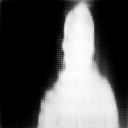

Epoch : 1031/2000
Model Loss(Batch: 0): [0.23785410821437836, 0.8986334204673767]
Epoch : 1032/2000
Model Loss(Batch: 0): [0.2331465631723404, 0.9002683162689209]
Epoch : 1033/2000
Model Loss(Batch: 0): [0.22836630046367645, 0.9017540216445923]
Epoch : 1034/2000
Model Loss(Batch: 0): [0.22322997450828552, 0.9036961793899536]
Epoch : 1035/2000
Model Loss(Batch: 0): [0.21886079013347626, 0.9056869745254517]
Epoch : 1036/2000
Model Loss(Batch: 0): [0.21535535156726837, 0.9072514176368713]
Epoch : 1037/2000
Model Loss(Batch: 0): [0.21156468987464905, 0.9085487127304077]
Epoch : 1038/2000
Model Loss(Batch: 0): [0.2076316922903061, 0.9098538160324097]
Epoch : 1039/2000
Model Loss(Batch: 0): [0.20295028388500214, 0.9119254350662231]
Epoch : 1040/2000
Model Loss(Batch: 0): [0.19786013662815094, 0.9145832061767578]


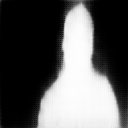

Epoch : 1041/2000
Model Loss(Batch: 0): [0.19364160299301147, 0.9168562293052673]
Epoch : 1042/2000
Model Loss(Batch: 0): [0.18987354636192322, 0.9186744689941406]
Epoch : 1043/2000
Model Loss(Batch: 0): [0.1861536204814911, 0.9201180338859558]
Epoch : 1044/2000
Model Loss(Batch: 0): [0.18203331530094147, 0.9218384027481079]
Epoch : 1045/2000
Model Loss(Batch: 0): [0.1773160994052887, 0.9239316582679749]
Epoch : 1046/2000
Model Loss(Batch: 0): [0.17276011407375336, 0.9260578155517578]
Epoch : 1047/2000
Model Loss(Batch: 0): [0.16849254071712494, 0.9279124140739441]
Epoch : 1048/2000
Model Loss(Batch: 0): [0.16434346139431, 0.929572582244873]
Epoch : 1049/2000
Model Loss(Batch: 0): [0.16004882752895355, 0.9314101934432983]
Epoch : 1050/2000
Model Loss(Batch: 0): [0.15549255907535553, 0.9335904121398926]


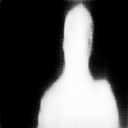

Epoch : 1051/2000
Model Loss(Batch: 0): [0.1508234441280365, 0.9357125163078308]
Epoch : 1052/2000
Model Loss(Batch: 0): [0.14617539942264557, 0.9375622868537903]
Epoch : 1053/2000
Model Loss(Batch: 0): [0.14155791699886322, 0.9398050308227539]
Epoch : 1054/2000
Model Loss(Batch: 0): [0.1372424215078354, 0.9414628744125366]
Epoch : 1055/2000
Model Loss(Batch: 0): [0.13279160857200623, 0.9433972835540771]
Epoch : 1056/2000
Model Loss(Batch: 0): [0.1279570460319519, 0.9454566836357117]
Epoch : 1057/2000
Model Loss(Batch: 0): [0.12372583895921707, 0.9469185471534729]
Epoch : 1058/2000
Model Loss(Batch: 0): [0.120327427983284, 0.9487864375114441]
Epoch : 1059/2000
Model Loss(Batch: 0): [0.11744429171085358, 0.9491612911224365]
Epoch : 1060/2000
Model Loss(Batch: 0): [0.1146816536784172, 0.9512855410575867]


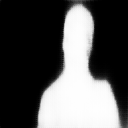

Epoch : 1061/2000
Model Loss(Batch: 0): [0.10968923568725586, 0.9525502324104309]
Epoch : 1062/2000
Model Loss(Batch: 0): [0.10607259720563889, 0.9540495872497559]
Epoch : 1063/2000
Model Loss(Batch: 0): [0.10399268567562103, 0.9553338289260864]
Epoch : 1064/2000
Model Loss(Batch: 0): [0.09999844431877136, 0.9564476013183594]
Epoch : 1065/2000
Model Loss(Batch: 0): [0.09695783257484436, 0.9576475024223328]
Epoch : 1066/2000
Model Loss(Batch: 0): [0.09460809826850891, 0.9589414596557617]
Epoch : 1067/2000
Model Loss(Batch: 0): [0.09118267893791199, 0.9599899649620056]
Epoch : 1068/2000
Model Loss(Batch: 0): [0.08879610896110535, 0.9607722759246826]
Epoch : 1069/2000
Model Loss(Batch: 0): [0.08662544190883636, 0.9618600010871887]
Epoch : 1070/2000
Model Loss(Batch: 0): [0.08359470963478088, 0.962806224822998]


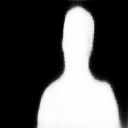

Epoch : 1071/2000
Model Loss(Batch: 0): [0.0812361091375351, 0.9637331366539001]
Epoch : 1072/2000
Model Loss(Batch: 0): [0.07966449111700058, 0.9645290970802307]
Epoch : 1073/2000
Model Loss(Batch: 0): [0.07750693708658218, 0.9649733901023865]
Epoch : 1074/2000
Model Loss(Batch: 0): [0.07498136162757874, 0.9663153290748596]
Epoch : 1075/2000
Model Loss(Batch: 0): [0.07278051972389221, 0.9670961499214172]
Epoch : 1076/2000
Model Loss(Batch: 0): [0.07119642943143845, 0.9675705432891846]
Epoch : 1077/2000
Model Loss(Batch: 0): [0.07023271173238754, 0.9681209325790405]
Epoch : 1078/2000
Model Loss(Batch: 0): [0.06978508830070496, 0.9676393866539001]
Epoch : 1079/2000
Model Loss(Batch: 0): [0.06965522468090057, 0.9682661294937134]
Epoch : 1080/2000
Model Loss(Batch: 0): [0.06697079539299011, 0.9687813520431519]


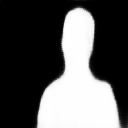

Epoch : 1081/2000
Model Loss(Batch: 0): [0.06350010633468628, 0.9706275463104248]
Epoch : 1082/2000
Model Loss(Batch: 0): [0.06256595253944397, 0.9710522890090942]
Epoch : 1083/2000
Model Loss(Batch: 0): [0.062475401908159256, 0.9705951809883118]
Epoch : 1084/2000
Model Loss(Batch: 0): [0.06046704202890396, 0.9718894958496094]
Epoch : 1085/2000
Model Loss(Batch: 0): [0.05853918194770813, 0.972592294216156]
Epoch : 1086/2000
Model Loss(Batch: 0): [0.058432649821043015, 0.9723319411277771]
Epoch : 1087/2000
Model Loss(Batch: 0): [0.05731556937098503, 0.9730671048164368]
Epoch : 1088/2000
Model Loss(Batch: 0): [0.055239129811525345, 0.9737645387649536]
Epoch : 1089/2000
Model Loss(Batch: 0): [0.05480945482850075, 0.9737508893013]
Epoch : 1090/2000
Model Loss(Batch: 0): [0.05443082004785538, 0.974120020866394]


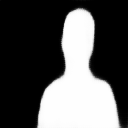

Epoch : 1091/2000
Model Loss(Batch: 0): [0.052450429648160934, 0.9748067855834961]
Epoch : 1092/2000
Model Loss(Batch: 0): [0.05141008272767067, 0.9752140641212463]
Epoch : 1093/2000
Model Loss(Batch: 0): [0.05136388912796974, 0.9753302335739136]
Epoch : 1094/2000
Model Loss(Batch: 0): [0.050295889377593994, 0.9755032062530518]
Epoch : 1095/2000
Model Loss(Batch: 0): [0.048791199922561646, 0.9763261675834656]
Epoch : 1096/2000
Model Loss(Batch: 0): [0.04795115068554878, 0.9766378402709961]
Epoch : 1097/2000
Model Loss(Batch: 0): [0.04770800471305847, 0.97649747133255]
Epoch : 1098/2000
Model Loss(Batch: 0): [0.047350265085697174, 0.9768449664115906]
Epoch : 1099/2000
Model Loss(Batch: 0): [0.046156466007232666, 0.9771237969398499]
Epoch : 1100/2000
Model Loss(Batch: 0): [0.04500282183289528, 0.9777562618255615]


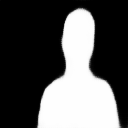

Epoch : 1101/2000
Model Loss(Batch: 0): [0.044219985604286194, 0.9780555367469788]
Epoch : 1102/2000
Model Loss(Batch: 0): [0.043901365250349045, 0.9780258536338806]
Epoch : 1103/2000
Model Loss(Batch: 0): [0.04367061331868172, 0.9782552719116211]
Epoch : 1104/2000
Model Loss(Batch: 0): [0.043171148747205734, 0.9782129526138306]
Epoch : 1105/2000
Model Loss(Batch: 0): [0.04252941533923149, 0.9786433577537537]
Epoch : 1106/2000
Model Loss(Batch: 0): [0.041521571576595306, 0.9789516925811768]
Epoch : 1107/2000
Model Loss(Batch: 0): [0.04068181291222572, 0.979399561882019]
Epoch : 1108/2000
Model Loss(Batch: 0): [0.04001803323626518, 0.9796578288078308]
Epoch : 1109/2000
Model Loss(Batch: 0): [0.03958822041749954, 0.9797903895378113]
Epoch : 1110/2000
Model Loss(Batch: 0): [0.039340000599622726, 0.9798851013183594]


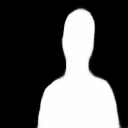

Epoch : 1111/2000
Model Loss(Batch: 0): [0.039289042353630066, 0.979767918586731]
Epoch : 1112/2000
Model Loss(Batch: 0): [0.039900392293930054, 0.9795553088188171]
Epoch : 1113/2000
Model Loss(Batch: 0): [0.04081900417804718, 0.9788001775741577]
Epoch : 1114/2000
Model Loss(Batch: 0): [0.043055664747953415, 0.9779355525970459]
Epoch : 1115/2000
Model Loss(Batch: 0): [0.04122614488005638, 0.9785318374633789]
Epoch : 1116/2000
Model Loss(Batch: 0): [0.03813304752111435, 0.9802241921424866]
Epoch : 1117/2000
Model Loss(Batch: 0): [0.03619889169931412, 0.981186032295227]
Epoch : 1118/2000
Model Loss(Batch: 0): [0.037879154086112976, 0.9801947474479675]
Epoch : 1119/2000
Model Loss(Batch: 0): [0.03921585530042648, 0.9795412421226501]
Epoch : 1120/2000
Model Loss(Batch: 0): [0.03603082522749901, 0.9810723662376404]


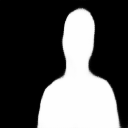

Epoch : 1121/2000
Model Loss(Batch: 0): [0.03508723899722099, 0.9815278053283691]
Epoch : 1122/2000
Model Loss(Batch: 0): [0.036751341074705124, 0.9806990027427673]
Epoch : 1123/2000
Model Loss(Batch: 0): [0.03571457043290138, 0.9810990691184998]
Epoch : 1124/2000
Model Loss(Batch: 0): [0.03393419459462166, 0.9820590019226074]
Epoch : 1125/2000
Model Loss(Batch: 0): [0.03398125618696213, 0.9819843173027039]
Epoch : 1126/2000
Model Loss(Batch: 0): [0.03459865599870682, 0.9815282225608826]
Epoch : 1127/2000
Model Loss(Batch: 0): [0.0340215303003788, 0.9818582534790039]
Epoch : 1128/2000
Model Loss(Batch: 0): [0.032700128853321075, 0.9824679493904114]
Epoch : 1129/2000
Model Loss(Batch: 0): [0.03260495513677597, 0.9824530482292175]
Epoch : 1130/2000
Model Loss(Batch: 0): [0.03322134539484978, 0.9821259379386902]


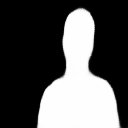

Epoch : 1131/2000
Model Loss(Batch: 0): [0.03282230347394943, 0.9822259545326233]
Epoch : 1132/2000
Model Loss(Batch: 0): [0.03194626420736313, 0.9827097654342651]
Epoch : 1133/2000
Model Loss(Batch: 0): [0.03125447779893875, 0.9829882383346558]
Epoch : 1134/2000
Model Loss(Batch: 0): [0.031248848885297775, 0.9829301238059998]
Epoch : 1135/2000
Model Loss(Batch: 0): [0.03161560744047165, 0.9827666282653809]
Epoch : 1136/2000
Model Loss(Batch: 0): [0.0316324383020401, 0.9826251864433289]
Epoch : 1137/2000
Model Loss(Batch: 0): [0.03137616068124771, 0.982817530632019]
Epoch : 1138/2000
Model Loss(Batch: 0): [0.030615609139204025, 0.98309725522995]
Epoch : 1139/2000
Model Loss(Batch: 0): [0.030005674809217453, 0.9834687113761902]
Epoch : 1140/2000
Model Loss(Batch: 0): [0.029612593352794647, 0.9835983514785767]


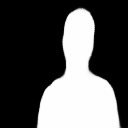

Epoch : 1141/2000
Model Loss(Batch: 0): [0.029502658173441887, 0.983600914478302]
Epoch : 1142/2000
Model Loss(Batch: 0): [0.02957182191312313, 0.9835906028747559]
Epoch : 1143/2000
Model Loss(Batch: 0): [0.029752429574728012, 0.9833856225013733]
Epoch : 1144/2000
Model Loss(Batch: 0): [0.030235014855861664, 0.983197033405304]
Epoch : 1145/2000
Model Loss(Batch: 0): [0.03069305792450905, 0.9828541874885559]
Epoch : 1146/2000
Model Loss(Batch: 0): [0.031914643943309784, 0.982250988483429]
Epoch : 1147/2000
Model Loss(Batch: 0): [0.03198707848787308, 0.9821518659591675]
Epoch : 1148/2000
Model Loss(Batch: 0): [0.03225075826048851, 0.9820541739463806]
Epoch : 1149/2000
Model Loss(Batch: 0): [0.02977369911968708, 0.9832649827003479]
Epoch : 1150/2000
Model Loss(Batch: 0): [0.027997523546218872, 0.984225332736969]


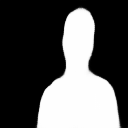

Epoch : 1151/2000
Model Loss(Batch: 0): [0.0280687864869833, 0.9841704368591309]
Epoch : 1152/2000
Model Loss(Batch: 0): [0.029136434197425842, 0.9835188388824463]
Epoch : 1153/2000
Model Loss(Batch: 0): [0.029728613793849945, 0.9832338690757751]
Epoch : 1154/2000
Model Loss(Batch: 0): [0.028246326372027397, 0.9839551448822021]
Epoch : 1155/2000
Model Loss(Batch: 0): [0.027120066806674004, 0.9845960140228271]
Epoch : 1156/2000
Model Loss(Batch: 0): [0.027309514582157135, 0.9844739437103271]
Epoch : 1157/2000
Model Loss(Batch: 0): [0.028010334819555283, 0.983986496925354]
Epoch : 1158/2000
Model Loss(Batch: 0): [0.02829904854297638, 0.9838538765907288]
Epoch : 1159/2000
Model Loss(Batch: 0): [0.027326975017786026, 0.9843299388885498]
Epoch : 1160/2000
Model Loss(Batch: 0): [0.026448296383023262, 0.9848239421844482]


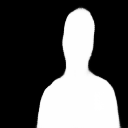

Epoch : 1161/2000
Model Loss(Batch: 0): [0.026319188997149467, 0.984860360622406]
Epoch : 1162/2000
Model Loss(Batch: 0): [0.02671832963824272, 0.9845484495162964]
Epoch : 1163/2000
Model Loss(Batch: 0): [0.027176309376955032, 0.9843350052833557]
Epoch : 1164/2000
Model Loss(Batch: 0): [0.02694798819720745, 0.9843836426734924]
Epoch : 1165/2000
Model Loss(Batch: 0): [0.02649952471256256, 0.9846705198287964]
Epoch : 1166/2000
Model Loss(Batch: 0): [0.025852307677268982, 0.9849270582199097]
Epoch : 1167/2000
Model Loss(Batch: 0): [0.025441985577344894, 0.9851558208465576]
Epoch : 1168/2000
Model Loss(Batch: 0): [0.025295671075582504, 0.9852099418640137]
Epoch : 1169/2000
Model Loss(Batch: 0): [0.02537538670003414, 0.9851204752922058]
Epoch : 1170/2000
Model Loss(Batch: 0): [0.025619398802518845, 0.9850068092346191]


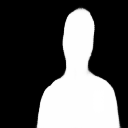

Epoch : 1171/2000
Model Loss(Batch: 0): [0.025970498099923134, 0.9847479462623596]
Epoch : 1172/2000
Model Loss(Batch: 0): [0.026794398203492165, 0.9843809008598328]
Epoch : 1173/2000
Model Loss(Batch: 0): [0.027558736503124237, 0.9839256405830383]
Epoch : 1174/2000
Model Loss(Batch: 0): [0.029635705053806305, 0.9829467535018921]
Epoch : 1175/2000
Model Loss(Batch: 0): [0.02954670414328575, 0.9830105304718018]
Epoch : 1176/2000
Model Loss(Batch: 0): [0.02942216768860817, 0.9829960465431213]
Epoch : 1177/2000
Model Loss(Batch: 0): [0.025861503556370735, 0.9847373962402344]
Epoch : 1178/2000
Model Loss(Batch: 0): [0.02437366545200348, 0.9855452179908752]
Epoch : 1179/2000
Model Loss(Batch: 0): [0.025656387209892273, 0.984864354133606]
Epoch : 1180/2000
Model Loss(Batch: 0): [0.02654971368610859, 0.9843604564666748]


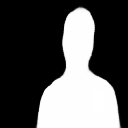

Epoch : 1181/2000
Model Loss(Batch: 0): [0.02596614696085453, 0.9846934080123901]
Epoch : 1182/2000
Model Loss(Batch: 0): [0.024133846163749695, 0.9856300354003906]
Epoch : 1183/2000
Model Loss(Batch: 0): [0.024429459124803543, 0.9854549169540405]
Epoch : 1184/2000
Model Loss(Batch: 0): [0.02575555630028248, 0.9847792983055115]
Epoch : 1185/2000
Model Loss(Batch: 0): [0.025073381140828133, 0.9850587844848633]
Epoch : 1186/2000
Model Loss(Batch: 0): [0.02384069375693798, 0.985733151435852]
Epoch : 1187/2000
Model Loss(Batch: 0): [0.023676622658967972, 0.9858149886131287]
Epoch : 1188/2000
Model Loss(Batch: 0): [0.02439049631357193, 0.985339343547821]
Epoch : 1189/2000
Model Loss(Batch: 0): [0.024750953540205956, 0.9851905703544617]
Epoch : 1190/2000
Model Loss(Batch: 0): [0.023744864389300346, 0.9856559038162231]


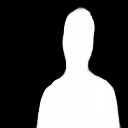

Epoch : 1191/2000
Model Loss(Batch: 0): [0.023150278255343437, 0.9859998226165771]
Epoch : 1192/2000
Model Loss(Batch: 0): [0.02341904118657112, 0.985835611820221]
Epoch : 1193/2000
Model Loss(Batch: 0): [0.023789318278431892, 0.9855721592903137]
Epoch : 1194/2000
Model Loss(Batch: 0): [0.02382214553654194, 0.9856035113334656]
Epoch : 1195/2000
Model Loss(Batch: 0): [0.023240644484758377, 0.9858299493789673]
Epoch : 1196/2000
Model Loss(Batch: 0): [0.02285272814333439, 0.9860541224479675]
Epoch : 1197/2000
Model Loss(Batch: 0): [0.022727878764271736, 0.9860978722572327]
Epoch : 1198/2000
Model Loss(Batch: 0): [0.022837340831756592, 0.9860216975212097]
Epoch : 1199/2000
Model Loss(Batch: 0): [0.0229425560683012, 0.9859810471534729]
Epoch : 1200/2000
Model Loss(Batch: 0): [0.022958965972065926, 0.9858796000480652]


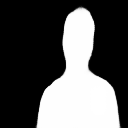

Epoch : 1201/2000
Model Loss(Batch: 0): [0.023077555000782013, 0.9858770966529846]
Epoch : 1202/2000
Model Loss(Batch: 0): [0.02303089201450348, 0.9858455061912537]
Epoch : 1203/2000
Model Loss(Batch: 0): [0.023204391822218895, 0.9858005046844482]
Epoch : 1204/2000
Model Loss(Batch: 0): [0.02281925268471241, 0.9859318137168884]
Epoch : 1205/2000
Model Loss(Batch: 0): [0.02258349023759365, 0.9860631227493286]
Epoch : 1206/2000
Model Loss(Batch: 0): [0.022289900109171867, 0.9861631393432617]
Epoch : 1207/2000
Model Loss(Batch: 0): [0.022319836542010307, 0.9861811995506287]
Epoch : 1208/2000
Model Loss(Batch: 0): [0.02237609587609768, 0.9861363768577576]
Epoch : 1209/2000
Model Loss(Batch: 0): [0.022335203364491463, 0.9861425161361694]
Epoch : 1210/2000
Model Loss(Batch: 0): [0.022161154076457024, 0.9862081408500671]


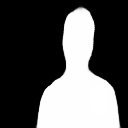

Epoch : 1211/2000
Model Loss(Batch: 0): [0.022335581481456757, 0.9861290454864502]
Epoch : 1212/2000
Model Loss(Batch: 0): [0.022714633494615555, 0.9858863353729248]
Epoch : 1213/2000
Model Loss(Batch: 0): [0.02391110174357891, 0.9853515625]
Epoch : 1214/2000
Model Loss(Batch: 0): [0.02465982362627983, 0.9849552512168884]
Epoch : 1215/2000
Model Loss(Batch: 0): [0.027529943734407425, 0.9836068153381348]
Epoch : 1216/2000
Model Loss(Batch: 0): [0.028448887169361115, 0.9833236932754517]
Epoch : 1217/2000
Model Loss(Batch: 0): [0.030112851411104202, 0.9825184941291809]
Epoch : 1218/2000
Model Loss(Batch: 0): [0.024317871779203415, 0.9851534962654114]
Epoch : 1219/2000
Model Loss(Batch: 0): [0.021740123629570007, 0.9864049553871155]
Epoch : 1220/2000
Model Loss(Batch: 0): [0.023959370329976082, 0.9853185415267944]


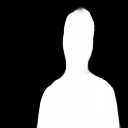

Epoch : 1221/2000
Model Loss(Batch: 0): [0.0245217252522707, 0.9850165247917175]
Epoch : 1222/2000
Model Loss(Batch: 0): [0.02319256216287613, 0.9857242703437805]
Epoch : 1223/2000
Model Loss(Batch: 0): [0.021630162373185158, 0.9864630103111267]
Epoch : 1224/2000
Model Loss(Batch: 0): [0.023396389558911324, 0.985558032989502]
Epoch : 1225/2000
Model Loss(Batch: 0): [0.02434724196791649, 0.9851415157318115]
Epoch : 1226/2000
Model Loss(Batch: 0): [0.021568231284618378, 0.9864704012870789]
Epoch : 1227/2000
Model Loss(Batch: 0): [0.022683029994368553, 0.9858996272087097]
Epoch : 1228/2000
Model Loss(Batch: 0): [0.024364866316318512, 0.9851291179656982]
Epoch : 1229/2000
Model Loss(Batch: 0): [0.02210979536175728, 0.9861841797828674]
Epoch : 1230/2000
Model Loss(Batch: 0): [0.022254135459661484, 0.9860875606536865]


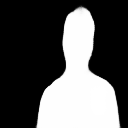

Epoch : 1231/2000
Model Loss(Batch: 0): [0.02322307415306568, 0.9855828881263733]
Epoch : 1232/2000
Model Loss(Batch: 0): [0.022875025868415833, 0.9857990145683289]
Epoch : 1233/2000
Model Loss(Batch: 0): [0.021592386066913605, 0.986423671245575]
Epoch : 1234/2000
Model Loss(Batch: 0): [0.021559761837124825, 0.9863691926002502]
Epoch : 1235/2000
Model Loss(Batch: 0): [0.022537998855113983, 0.9859476089477539]
Epoch : 1236/2000
Model Loss(Batch: 0): [0.021150808781385422, 0.9866034388542175]
Epoch : 1237/2000
Model Loss(Batch: 0): [0.02107366733253002, 0.9866223335266113]
Epoch : 1238/2000
Model Loss(Batch: 0): [0.021226108074188232, 0.986533522605896]
Epoch : 1239/2000
Model Loss(Batch: 0): [0.02130516991019249, 0.9864830374717712]
Epoch : 1240/2000
Model Loss(Batch: 0): [0.020617086440324783, 0.9868069291114807]


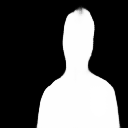

Epoch : 1241/2000
Model Loss(Batch: 0): [0.020512515679001808, 0.986846923828125]
Epoch : 1242/2000
Model Loss(Batch: 0): [0.020960921421647072, 0.9866147637367249]
Epoch : 1243/2000
Model Loss(Batch: 0): [0.020583361387252808, 0.9867947101593018]
Epoch : 1244/2000
Model Loss(Batch: 0): [0.020422393456101418, 0.9868822693824768]
Epoch : 1245/2000
Model Loss(Batch: 0): [0.020092450082302094, 0.9870331883430481]
Epoch : 1246/2000
Model Loss(Batch: 0): [0.020550524815917015, 0.986790120601654]
Epoch : 1247/2000
Model Loss(Batch: 0): [0.020425759255886078, 0.986827552318573]
Epoch : 1248/2000
Model Loss(Batch: 0): [0.020233722403645515, 0.9869166016578674]
Epoch : 1249/2000
Model Loss(Batch: 0): [0.020040757954120636, 0.9870140552520752]
Epoch : 1250/2000
Model Loss(Batch: 0): [0.01977457106113434, 0.9871537685394287]


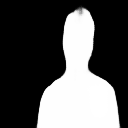

Epoch : 1251/2000
Model Loss(Batch: 0): [0.020030884072184563, 0.9869828820228577]
Epoch : 1252/2000
Model Loss(Batch: 0): [0.02004341222345829, 0.9869877099990845]
Epoch : 1253/2000
Model Loss(Batch: 0): [0.02014974318444729, 0.9869130253791809]
Epoch : 1254/2000
Model Loss(Batch: 0): [0.020052358508110046, 0.9869435429573059]
Epoch : 1255/2000
Model Loss(Batch: 0): [0.019857551902532578, 0.9870356917381287]
Epoch : 1256/2000
Model Loss(Batch: 0): [0.019736014306545258, 0.987106204032898]
Epoch : 1257/2000
Model Loss(Batch: 0): [0.01949322037398815, 0.987210214138031]
Epoch : 1258/2000
Model Loss(Batch: 0): [0.019473504275083542, 0.9872072339057922]
Epoch : 1259/2000
Model Loss(Batch: 0): [0.01929701864719391, 0.9872968792915344]
Epoch : 1260/2000
Model Loss(Batch: 0): [0.019346991553902626, 0.9872645139694214]


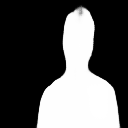

Epoch : 1261/2000
Model Loss(Batch: 0): [0.01930389739573002, 0.9872663617134094]
Epoch : 1262/2000
Model Loss(Batch: 0): [0.019351709634065628, 0.9872474670410156]
Epoch : 1263/2000
Model Loss(Batch: 0): [0.01955731213092804, 0.9871276617050171]
Epoch : 1264/2000
Model Loss(Batch: 0): [0.019833998754620552, 0.9869530200958252]
Epoch : 1265/2000
Model Loss(Batch: 0): [0.020895570516586304, 0.9864489436149597]
Epoch : 1266/2000
Model Loss(Batch: 0): [0.02262469194829464, 0.985649585723877]
Epoch : 1267/2000
Model Loss(Batch: 0): [0.02775142341852188, 0.9834741950035095]
Epoch : 1268/2000
Model Loss(Batch: 0): [0.031048988923430443, 0.9823328256607056]
Epoch : 1269/2000
Model Loss(Batch: 0): [0.039447955787181854, 0.9791794419288635]
Epoch : 1270/2000
Model Loss(Batch: 0): [0.025670694187283516, 0.9845359921455383]


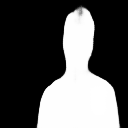

Epoch : 1271/2000
Model Loss(Batch: 0): [0.020630940794944763, 0.9866514205932617]
Epoch : 1272/2000
Model Loss(Batch: 0): [0.027656983584165573, 0.983570396900177]
Epoch : 1273/2000
Model Loss(Batch: 0): [0.02298859879374504, 0.9856285452842712]
Epoch : 1274/2000
Model Loss(Batch: 0): [0.021163636818528175, 0.9864529371261597]
Epoch : 1275/2000
Model Loss(Batch: 0): [0.0242121871560812, 0.984963059425354]
Epoch : 1276/2000
Model Loss(Batch: 0): [0.020891448482871056, 0.986660897731781]
Epoch : 1277/2000
Model Loss(Batch: 0): [0.021631279960274696, 0.9862852096557617]
Epoch : 1278/2000
Model Loss(Batch: 0): [0.022514356300234795, 0.9857704043388367]
Epoch : 1279/2000
Model Loss(Batch: 0): [0.02001357264816761, 0.9870262145996094]
Epoch : 1280/2000
Model Loss(Batch: 0): [0.022434242069721222, 0.9859164357185364]


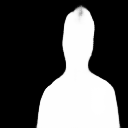

Epoch : 1281/2000
Model Loss(Batch: 0): [0.02085454948246479, 0.9866284728050232]
Epoch : 1282/2000
Model Loss(Batch: 0): [0.02038523554801941, 0.9868381023406982]
Epoch : 1283/2000
Model Loss(Batch: 0): [0.02175646461546421, 0.9861294627189636]
Epoch : 1284/2000
Model Loss(Batch: 0): [0.019620629027485847, 0.987197995185852]
Epoch : 1285/2000
Model Loss(Batch: 0): [0.020549776032567024, 0.9867187738418579]
Epoch : 1286/2000
Model Loss(Batch: 0): [0.02014363929629326, 0.9868782758712769]
Epoch : 1287/2000
Model Loss(Batch: 0): [0.019413435831665993, 0.9872512221336365]
Epoch : 1288/2000
Model Loss(Batch: 0): [0.02007615752518177, 0.986870288848877]
Epoch : 1289/2000
Model Loss(Batch: 0): [0.01944046840071678, 0.9872350096702576]
Epoch : 1290/2000
Model Loss(Batch: 0): [0.019189933314919472, 0.9873219728469849]


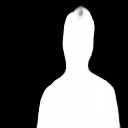

Epoch : 1291/2000
Model Loss(Batch: 0): [0.019680248573422432, 0.987037181854248]
Epoch : 1292/2000
Model Loss(Batch: 0): [0.01891620270907879, 0.9874383211135864]
Epoch : 1293/2000
Model Loss(Batch: 0): [0.01908193528652191, 0.9873375296592712]
Epoch : 1294/2000
Model Loss(Batch: 0): [0.019345665350556374, 0.9871826171875]
Epoch : 1295/2000
Model Loss(Batch: 0): [0.01865405961871147, 0.987522542476654]
Epoch : 1296/2000
Model Loss(Batch: 0): [0.01888994313776493, 0.9874038100242615]
Epoch : 1297/2000
Model Loss(Batch: 0): [0.018955141305923462, 0.9873402714729309]
Epoch : 1298/2000
Model Loss(Batch: 0): [0.018602196127176285, 0.9875054955482483]
Epoch : 1299/2000
Model Loss(Batch: 0): [0.018429206684231758, 0.9875951409339905]
Epoch : 1300/2000
Model Loss(Batch: 0): [0.018742913380265236, 0.987399160861969]


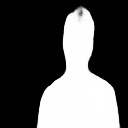

Epoch : 1301/2000
Model Loss(Batch: 0): [0.018428627401590347, 0.9875504970550537]
Epoch : 1302/2000
Model Loss(Batch: 0): [0.018246229737997055, 0.9876397252082825]
Epoch : 1303/2000
Model Loss(Batch: 0): [0.018351949751377106, 0.9875761866569519]
Epoch : 1304/2000
Model Loss(Batch: 0): [0.018397577106952667, 0.9875534772872925]
Epoch : 1305/2000
Model Loss(Batch: 0): [0.018185723572969437, 0.9876406192779541]
Epoch : 1306/2000
Model Loss(Batch: 0): [0.0180550217628479, 0.9876989126205444]
Epoch : 1307/2000
Model Loss(Batch: 0): [0.018121199682354927, 0.9876527786254883]
Epoch : 1308/2000
Model Loss(Batch: 0): [0.018178755417466164, 0.9876130223274231]
Epoch : 1309/2000
Model Loss(Batch: 0): [0.018065858632326126, 0.9876585006713867]
Epoch : 1310/2000
Model Loss(Batch: 0): [0.017922108992934227, 0.9877456426620483]


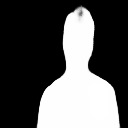

Epoch : 1311/2000
Model Loss(Batch: 0): [0.017853617668151855, 0.9877609610557556]
Epoch : 1312/2000
Model Loss(Batch: 0): [0.017908427864313126, 0.9877232909202576]
Epoch : 1313/2000
Model Loss(Batch: 0): [0.017933493480086327, 0.9877138137817383]
Epoch : 1314/2000
Model Loss(Batch: 0): [0.017894882708787918, 0.9877173900604248]
Epoch : 1315/2000
Model Loss(Batch: 0): [0.017814740538597107, 0.9877389073371887]
Epoch : 1316/2000
Model Loss(Batch: 0): [0.017694907262921333, 0.9878110885620117]
Epoch : 1317/2000
Model Loss(Batch: 0): [0.017651358619332314, 0.9878201484680176]
Epoch : 1318/2000
Model Loss(Batch: 0): [0.01762482523918152, 0.9878363013267517]
Epoch : 1319/2000
Model Loss(Batch: 0): [0.017627663910388947, 0.9878239035606384]
Epoch : 1320/2000
Model Loss(Batch: 0): [0.017655014991760254, 0.9878007769584656]


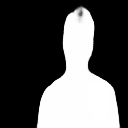

Epoch : 1321/2000
Model Loss(Batch: 0): [0.017663057893514633, 0.9877942204475403]
Epoch : 1322/2000
Model Loss(Batch: 0): [0.017679646611213684, 0.9877914786338806]
Epoch : 1323/2000
Model Loss(Batch: 0): [0.01769334264099598, 0.9877841472625732]
Epoch : 1324/2000
Model Loss(Batch: 0): [0.017739301547408104, 0.9877493977546692]
Epoch : 1325/2000
Model Loss(Batch: 0): [0.01778157241642475, 0.9877220392227173]
Epoch : 1326/2000
Model Loss(Batch: 0): [0.017955603078007698, 0.9876397252082825]
Epoch : 1327/2000
Model Loss(Batch: 0): [0.018125981092453003, 0.9875404238700867]
Epoch : 1328/2000
Model Loss(Batch: 0): [0.0186527781188488, 0.9873030185699463]
Epoch : 1329/2000
Model Loss(Batch: 0): [0.01921689510345459, 0.9870414137840271]
Epoch : 1330/2000
Model Loss(Batch: 0): [0.02066059410572052, 0.9863792657852173]


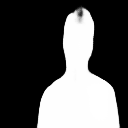

Epoch : 1331/2000
Model Loss(Batch: 0): [0.021372927352786064, 0.9860652685165405]
Epoch : 1332/2000
Model Loss(Batch: 0): [0.02332993410527706, 0.9852307438850403]
Epoch : 1333/2000
Model Loss(Batch: 0): [0.021599575877189636, 0.986033022403717]
Epoch : 1334/2000
Model Loss(Batch: 0): [0.019726676866412163, 0.986836850643158]
Epoch : 1335/2000
Model Loss(Batch: 0): [0.01755044236779213, 0.987827479839325]
Epoch : 1336/2000
Model Loss(Batch: 0): [0.017877504229545593, 0.9876755475997925]
Epoch : 1337/2000
Model Loss(Batch: 0): [0.019551033154129982, 0.9868839383125305]
Epoch : 1338/2000
Model Loss(Batch: 0): [0.019217243418097496, 0.9870508909225464]
Epoch : 1339/2000
Model Loss(Batch: 0): [0.01795206032693386, 0.9876338839530945]
Epoch : 1340/2000
Model Loss(Batch: 0): [0.017264846712350845, 0.9879729151725769]


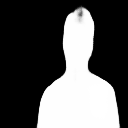

Epoch : 1341/2000
Model Loss(Batch: 0): [0.018124699592590332, 0.9875450134277344]
Epoch : 1342/2000
Model Loss(Batch: 0): [0.018880736082792282, 0.9871699810028076]
Epoch : 1343/2000
Model Loss(Batch: 0): [0.01790141686797142, 0.9876601696014404]
Epoch : 1344/2000
Model Loss(Batch: 0): [0.01716834120452404, 0.9879990220069885]
Epoch : 1345/2000
Model Loss(Batch: 0): [0.017530309036374092, 0.9878262281417847]
Epoch : 1346/2000
Model Loss(Batch: 0): [0.017962288111448288, 0.9876071214675903]
Epoch : 1347/2000
Model Loss(Batch: 0): [0.017855903133749962, 0.9876437187194824]
Epoch : 1348/2000
Model Loss(Batch: 0): [0.017255749553442, 0.9879594445228577]
Epoch : 1349/2000
Model Loss(Batch: 0): [0.01706736721098423, 0.9880366921424866]
Epoch : 1350/2000
Model Loss(Batch: 0): [0.017358142882585526, 0.9878821969032288]


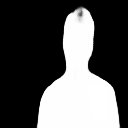

Epoch : 1351/2000
Model Loss(Batch: 0): [0.017570804804563522, 0.9877765774726868]
Epoch : 1352/2000
Model Loss(Batch: 0): [0.017496028915047646, 0.9878047704696655]
Epoch : 1353/2000
Model Loss(Batch: 0): [0.0170633252710104, 0.9880282878875732]
Epoch : 1354/2000
Model Loss(Batch: 0): [0.01686074025928974, 0.9881000518798828]
Epoch : 1355/2000
Model Loss(Batch: 0): [0.016982056200504303, 0.9880390167236328]
Epoch : 1356/2000
Model Loss(Batch: 0): [0.017180338501930237, 0.9879335761070251]
Epoch : 1357/2000
Model Loss(Batch: 0): [0.017312519252300262, 0.9878586530685425]
Epoch : 1358/2000
Model Loss(Batch: 0): [0.017186924815177917, 0.9879127144813538]
Epoch : 1359/2000
Model Loss(Batch: 0): [0.017029302194714546, 0.9879809021949768]
Epoch : 1360/2000
Model Loss(Batch: 0): [0.016830414533615112, 0.9880756139755249]


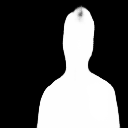

Epoch : 1361/2000
Model Loss(Batch: 0): [0.016723044216632843, 0.9881333112716675]
Epoch : 1362/2000
Model Loss(Batch: 0): [0.016691384837031364, 0.9881389737129211]
Epoch : 1363/2000
Model Loss(Batch: 0): [0.016688277944922447, 0.9881497025489807]
Epoch : 1364/2000
Model Loss(Batch: 0): [0.016701774671673775, 0.988120436668396]
Epoch : 1365/2000
Model Loss(Batch: 0): [0.01675313152372837, 0.9880998134613037]
Epoch : 1366/2000
Model Loss(Batch: 0): [0.01691461354494095, 0.9880324602127075]
Epoch : 1367/2000
Model Loss(Batch: 0): [0.01718519814312458, 0.9879169464111328]
Epoch : 1368/2000
Model Loss(Batch: 0): [0.01781494915485382, 0.9876178503036499]
Epoch : 1369/2000
Model Loss(Batch: 0): [0.0187178086489439, 0.9871767163276672]
Epoch : 1370/2000
Model Loss(Batch: 0): [0.02134747803211212, 0.9860530495643616]


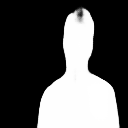

Epoch : 1371/2000
Model Loss(Batch: 0): [0.023784462362527847, 0.9851208925247192]
Epoch : 1372/2000
Model Loss(Batch: 0): [0.03103824518620968, 0.9824027419090271]
Epoch : 1373/2000
Model Loss(Batch: 0): [0.02875000610947609, 0.9834825992584229]
Epoch : 1374/2000
Model Loss(Batch: 0): [0.026184193789958954, 0.984207272529602]
Epoch : 1375/2000
Model Loss(Batch: 0): [0.01790083758533001, 0.9876161813735962]
Epoch : 1376/2000
Model Loss(Batch: 0): [0.022927356883883476, 0.9855464696884155]
Epoch : 1377/2000
Model Loss(Batch: 0): [0.026150910183787346, 0.984096348285675]
Epoch : 1378/2000
Model Loss(Batch: 0): [0.018679022789001465, 0.987334132194519]
Epoch : 1379/2000
Model Loss(Batch: 0): [0.023663697764277458, 0.9852520227432251]
Epoch : 1380/2000
Model Loss(Batch: 0): [0.02253725193440914, 0.9854721426963806]


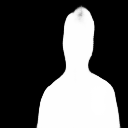

Epoch : 1381/2000
Model Loss(Batch: 0): [0.02082916349172592, 0.9863529801368713]
Epoch : 1382/2000
Model Loss(Batch: 0): [0.020156171172857285, 0.9867090582847595]
Epoch : 1383/2000
Model Loss(Batch: 0): [0.021997347474098206, 0.9859562516212463]
Epoch : 1384/2000
Model Loss(Batch: 0): [0.018200723454356194, 0.9875890016555786]
Epoch : 1385/2000
Model Loss(Batch: 0): [0.022404558956623077, 0.9858604669570923]
Epoch : 1386/2000
Model Loss(Batch: 0): [0.01890694536268711, 0.9872950315475464]
Epoch : 1387/2000
Model Loss(Batch: 0): [0.019813820719718933, 0.9868818521499634]
Epoch : 1388/2000
Model Loss(Batch: 0): [0.019478466361761093, 0.9870632886886597]
Epoch : 1389/2000
Model Loss(Batch: 0): [0.018621297553181648, 0.9873918294906616]
Epoch : 1390/2000
Model Loss(Batch: 0): [0.019141675904393196, 0.9871053695678711]


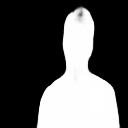

Epoch : 1391/2000
Model Loss(Batch: 0): [0.018266085535287857, 0.9875549077987671]
Epoch : 1392/2000
Model Loss(Batch: 0): [0.018395477905869484, 0.9874932765960693]
Epoch : 1393/2000
Model Loss(Batch: 0): [0.01820889487862587, 0.9875164031982422]
Epoch : 1394/2000
Model Loss(Batch: 0): [0.01805347204208374, 0.9876498579978943]
Epoch : 1395/2000
Model Loss(Batch: 0): [0.017673766240477562, 0.987800121307373]
Epoch : 1396/2000
Model Loss(Batch: 0): [0.017971687018871307, 0.9876616597175598]
Epoch : 1397/2000
Model Loss(Batch: 0): [0.017328709363937378, 0.9879226088523865]
Epoch : 1398/2000
Model Loss(Batch: 0): [0.017560765147209167, 0.9878160953521729]
Epoch : 1399/2000
Model Loss(Batch: 0): [0.0174714382737875, 0.987826406955719]
Epoch : 1400/2000
Model Loss(Batch: 0): [0.01696149818599224, 0.988078773021698]


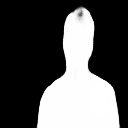

Epoch : 1401/2000
Model Loss(Batch: 0): [0.017337100580334663, 0.9878681302070618]
Epoch : 1402/2000
Model Loss(Batch: 0): [0.017046837136149406, 0.9879910349845886]
Epoch : 1403/2000
Model Loss(Batch: 0): [0.016746822744607925, 0.9881278276443481]
Epoch : 1404/2000
Model Loss(Batch: 0): [0.01705247536301613, 0.9879906177520752]
Epoch : 1405/2000
Model Loss(Batch: 0): [0.0167595986276865, 0.98809415102005]
Epoch : 1406/2000
Model Loss(Batch: 0): [0.016641750931739807, 0.9881450533866882]
Epoch : 1407/2000
Model Loss(Batch: 0): [0.01660815067589283, 0.9881615042686462]
Epoch : 1408/2000
Model Loss(Batch: 0): [0.016731008887290955, 0.9880890846252441]
Epoch : 1409/2000
Model Loss(Batch: 0): [0.016427593305706978, 0.9882376790046692]
Epoch : 1410/2000
Model Loss(Batch: 0): [0.016375167295336723, 0.988251805305481]


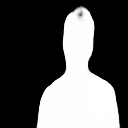

Epoch : 1411/2000
Model Loss(Batch: 0): [0.01649324968457222, 0.9881899356842041]
Epoch : 1412/2000
Model Loss(Batch: 0): [0.01638096012175083, 0.9882218837738037]
Epoch : 1413/2000
Model Loss(Batch: 0): [0.016242623329162598, 0.9882654547691345]
Epoch : 1414/2000
Model Loss(Batch: 0): [0.016179844737052917, 0.988304615020752]
Epoch : 1415/2000
Model Loss(Batch: 0): [0.016279520466923714, 0.9882622957229614]
Epoch : 1416/2000
Model Loss(Batch: 0): [0.016219986602663994, 0.9882814884185791]
Epoch : 1417/2000
Model Loss(Batch: 0): [0.01614685356616974, 0.9882999658584595]
Epoch : 1418/2000
Model Loss(Batch: 0): [0.01601424813270569, 0.9883624911308289]
Epoch : 1419/2000
Model Loss(Batch: 0): [0.016047148033976555, 0.9883565902709961]
Epoch : 1420/2000
Model Loss(Batch: 0): [0.016054313629865646, 0.9883326292037964]


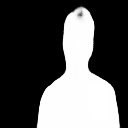

Epoch : 1421/2000
Model Loss(Batch: 0): [0.016068492084741592, 0.9883277416229248]
Epoch : 1422/2000
Model Loss(Batch: 0): [0.015981659293174744, 0.9883525967597961]
Epoch : 1423/2000
Model Loss(Batch: 0): [0.0159101914614439, 0.9883959293365479]
Epoch : 1424/2000
Model Loss(Batch: 0): [0.015860211104154587, 0.9884039759635925]
Epoch : 1425/2000
Model Loss(Batch: 0): [0.01583673246204853, 0.9883972406387329]
Epoch : 1426/2000
Model Loss(Batch: 0): [0.015845350921154022, 0.9884030818939209]
Epoch : 1427/2000
Model Loss(Batch: 0): [0.01585172861814499, 0.9883968234062195]
Epoch : 1428/2000
Model Loss(Batch: 0): [0.01585017517209053, 0.9884056448936462]
Epoch : 1429/2000
Model Loss(Batch: 0): [0.01583203673362732, 0.988402247428894]
Epoch : 1430/2000
Model Loss(Batch: 0): [0.01581669971346855, 0.988399088382721]


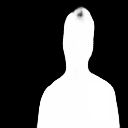

Epoch : 1431/2000
Model Loss(Batch: 0): [0.015788085758686066, 0.9884113073348999]
Epoch : 1432/2000
Model Loss(Batch: 0): [0.015768051147460938, 0.9884268641471863]
Epoch : 1433/2000
Model Loss(Batch: 0): [0.015749895945191383, 0.9884258508682251]
Epoch : 1434/2000
Model Loss(Batch: 0): [0.015747731551527977, 0.9884218573570251]
Epoch : 1435/2000
Model Loss(Batch: 0): [0.015757471323013306, 0.9884045720100403]
Epoch : 1436/2000
Model Loss(Batch: 0): [0.01581694558262825, 0.9883965849876404]
Epoch : 1437/2000
Model Loss(Batch: 0): [0.015914762392640114, 0.9883458614349365]
Epoch : 1438/2000
Model Loss(Batch: 0): [0.01618047244846821, 0.988219141960144]
Epoch : 1439/2000
Model Loss(Batch: 0): [0.016598988324403763, 0.9880263805389404]
Epoch : 1440/2000
Model Loss(Batch: 0): [0.017685679718852043, 0.9875311255455017]


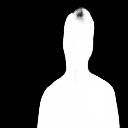

Epoch : 1441/2000
Model Loss(Batch: 0): [0.01906493306159973, 0.9869795441627502]
Epoch : 1442/2000
Model Loss(Batch: 0): [0.02270621992647648, 0.9855087995529175]
Epoch : 1443/2000
Model Loss(Batch: 0): [0.023962147533893585, 0.9851148128509521]
Epoch : 1444/2000
Model Loss(Batch: 0): [0.026450984179973602, 0.9840673208236694]
Epoch : 1445/2000
Model Loss(Batch: 0): [0.019911548122763634, 0.9867223501205444]
Epoch : 1446/2000
Model Loss(Batch: 0): [0.015945404767990112, 0.9883425235748291]
Epoch : 1447/2000
Model Loss(Batch: 0): [0.018198899924755096, 0.9873794317245483]
Epoch : 1448/2000
Model Loss(Batch: 0): [0.019535940140485764, 0.9868338704109192]
Epoch : 1449/2000
Model Loss(Batch: 0): [0.017283709719777107, 0.9877199530601501]
Epoch : 1450/2000
Model Loss(Batch: 0): [0.016169419512152672, 0.9882892370223999]


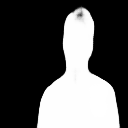

Epoch : 1451/2000
Model Loss(Batch: 0): [0.01820112019777298, 0.9873695373535156]
Epoch : 1452/2000
Model Loss(Batch: 0): [0.017937393859028816, 0.9874294996261597]
Epoch : 1453/2000
Model Loss(Batch: 0): [0.015892991796135902, 0.9884355068206787]
Epoch : 1454/2000
Model Loss(Batch: 0): [0.017414016649127007, 0.987720787525177]
Epoch : 1455/2000
Model Loss(Batch: 0): [0.017964407801628113, 0.987425684928894]
Epoch : 1456/2000
Model Loss(Batch: 0): [0.015886565670371056, 0.9884399175643921]
Epoch : 1457/2000
Model Loss(Batch: 0): [0.01692071743309498, 0.987941563129425]
Epoch : 1458/2000
Model Loss(Batch: 0): [0.01774275302886963, 0.9875277876853943]
Epoch : 1459/2000
Model Loss(Batch: 0): [0.015812551602721214, 0.988454282283783]
Epoch : 1460/2000
Model Loss(Batch: 0): [0.016553964465856552, 0.9881029725074768]


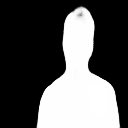

Epoch : 1461/2000
Model Loss(Batch: 0): [0.017477022483944893, 0.9876492023468018]
Epoch : 1462/2000
Model Loss(Batch: 0): [0.01579238288104534, 0.9884399175643921]
Epoch : 1463/2000
Model Loss(Batch: 0): [0.016216890886425972, 0.9882431626319885]
Epoch : 1464/2000
Model Loss(Batch: 0): [0.017072094604372978, 0.9878154993057251]
Epoch : 1465/2000
Model Loss(Batch: 0): [0.015854081138968468, 0.9883792996406555]
Epoch : 1466/2000
Model Loss(Batch: 0): [0.015876391902565956, 0.9883818626403809]
Epoch : 1467/2000
Model Loss(Batch: 0): [0.016539955511689186, 0.9880562424659729]
Epoch : 1468/2000
Model Loss(Batch: 0): [0.015919340774416924, 0.9883389472961426]
Epoch : 1469/2000
Model Loss(Batch: 0): [0.01568627916276455, 0.988453209400177]
Epoch : 1470/2000
Model Loss(Batch: 0): [0.015937117859721184, 0.9883037805557251]


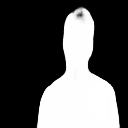

Epoch : 1471/2000
Model Loss(Batch: 0): [0.015866516157984734, 0.9883416295051575]
Epoch : 1472/2000
Model Loss(Batch: 0): [0.015783898532390594, 0.9883919358253479]
Epoch : 1473/2000
Model Loss(Batch: 0): [0.015505760908126831, 0.9884910583496094]
Epoch : 1474/2000
Model Loss(Batch: 0): [0.015535126440227032, 0.9884763360023499]
Epoch : 1475/2000
Model Loss(Batch: 0): [0.015827836468815804, 0.9883528351783752]
Epoch : 1476/2000
Model Loss(Batch: 0): [0.01549582276493311, 0.9884721636772156]
Epoch : 1477/2000
Model Loss(Batch: 0): [0.015191017650067806, 0.9886148571968079]
Epoch : 1478/2000
Model Loss(Batch: 0): [0.015436971560120583, 0.988525390625]
Epoch : 1479/2000
Model Loss(Batch: 0): [0.015493324026465416, 0.9884691834449768]
Epoch : 1480/2000
Model Loss(Batch: 0): [0.015260857529938221, 0.9885801076889038]


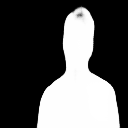

Epoch : 1481/2000
Model Loss(Batch: 0): [0.015193114057183266, 0.9886146187782288]
Epoch : 1482/2000
Model Loss(Batch: 0): [0.015229422599077225, 0.9885746240615845]
Epoch : 1483/2000
Model Loss(Batch: 0): [0.015150527469813824, 0.9886106252670288]
Epoch : 1484/2000
Model Loss(Batch: 0): [0.01519286073744297, 0.9885900020599365]
Epoch : 1485/2000
Model Loss(Batch: 0): [0.015274874866008759, 0.9885624051094055]
Epoch : 1486/2000
Model Loss(Batch: 0): [0.015107178129255772, 0.9886268377304077]
Epoch : 1487/2000
Model Loss(Batch: 0): [0.014992740005254745, 0.9886783957481384]
Epoch : 1488/2000
Model Loss(Batch: 0): [0.015021874569356441, 0.9886470437049866]
Epoch : 1489/2000
Model Loss(Batch: 0): [0.015023214742541313, 0.9886554479598999]
Epoch : 1490/2000
Model Loss(Batch: 0): [0.014992075972259045, 0.988670825958252]


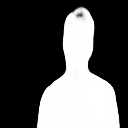

Epoch : 1491/2000
Model Loss(Batch: 0): [0.015013053081929684, 0.9886436462402344]
Epoch : 1492/2000
Model Loss(Batch: 0): [0.015069040469825268, 0.9886356592178345]
Epoch : 1493/2000
Model Loss(Batch: 0): [0.015051214024424553, 0.9886215925216675]
Epoch : 1494/2000
Model Loss(Batch: 0): [0.015027282759547234, 0.9886541962623596]
Epoch : 1495/2000
Model Loss(Batch: 0): [0.015026964247226715, 0.9886331558227539]
Epoch : 1496/2000
Model Loss(Batch: 0): [0.01507361326366663, 0.988619863986969]
Epoch : 1497/2000
Model Loss(Batch: 0): [0.015087952837347984, 0.9885963201522827]
Epoch : 1498/2000
Model Loss(Batch: 0): [0.015174658969044685, 0.9885773658752441]
Epoch : 1499/2000
Model Loss(Batch: 0): [0.015309834852814674, 0.9885009527206421]
Epoch : 1500/2000
Model Loss(Batch: 0): [0.01567159593105316, 0.9883370399475098]


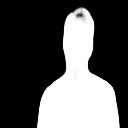

Epoch : 1501/2000
Model Loss(Batch: 0): [0.016166750341653824, 0.9881105422973633]
Epoch : 1502/2000
Model Loss(Batch: 0): [0.017444811761379242, 0.9875650405883789]
Epoch : 1503/2000
Model Loss(Batch: 0): [0.018772078678011894, 0.9870617985725403]
Epoch : 1504/2000
Model Loss(Batch: 0): [0.022117692977190018, 0.9856923222541809]
Epoch : 1505/2000
Model Loss(Batch: 0): [0.022478554397821426, 0.9856780171394348]
Epoch : 1506/2000
Model Loss(Batch: 0): [0.023415209725499153, 0.985180675983429]
Epoch : 1507/2000
Model Loss(Batch: 0): [0.01794211007654667, 0.987457275390625]
Epoch : 1508/2000
Model Loss(Batch: 0): [0.015157278627157211, 0.9885916709899902]
Epoch : 1509/2000
Model Loss(Batch: 0): [0.017153115943074226, 0.9877306818962097]
Epoch : 1510/2000
Model Loss(Batch: 0): [0.018170582130551338, 0.9873569011688232]


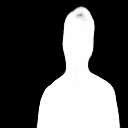

Epoch : 1511/2000
Model Loss(Batch: 0): [0.01646488346159458, 0.9880089163780212]
Epoch : 1512/2000
Model Loss(Batch: 0): [0.015243171714246273, 0.9885891675949097]
Epoch : 1513/2000
Model Loss(Batch: 0): [0.016827071085572243, 0.9878554940223694]
Epoch : 1514/2000
Model Loss(Batch: 0): [0.017198260873556137, 0.9876814484596252]
Epoch : 1515/2000
Model Loss(Batch: 0): [0.015232294797897339, 0.988593578338623]
Epoch : 1516/2000
Model Loss(Batch: 0): [0.01584150269627571, 0.9883092641830444]
Epoch : 1517/2000
Model Loss(Batch: 0): [0.01695641502737999, 0.9877849817276001]
Epoch : 1518/2000
Model Loss(Batch: 0): [0.015415617264807224, 0.9885209798812866]
Epoch : 1519/2000
Model Loss(Batch: 0): [0.015267275273799896, 0.988587498664856]
Epoch : 1520/2000
Model Loss(Batch: 0): [0.016291560605168343, 0.9880821704864502]


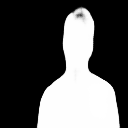

Epoch : 1521/2000
Model Loss(Batch: 0): [0.015566730871796608, 0.9884172081947327]
Epoch : 1522/2000
Model Loss(Batch: 0): [0.014875130727887154, 0.9887428283691406]
Epoch : 1523/2000
Model Loss(Batch: 0): [0.015562310814857483, 0.988414466381073]
Epoch : 1524/2000
Model Loss(Batch: 0): [0.015536627732217312, 0.9884315133094788]
Epoch : 1525/2000
Model Loss(Batch: 0): [0.014832254499197006, 0.9887398481369019]
Epoch : 1526/2000
Model Loss(Batch: 0): [0.01496436633169651, 0.9886756539344788]
Epoch : 1527/2000
Model Loss(Batch: 0): [0.015285425819456577, 0.9885205626487732]
Epoch : 1528/2000
Model Loss(Batch: 0): [0.015077498741447926, 0.988593578338623]
Epoch : 1529/2000
Model Loss(Batch: 0): [0.014717243611812592, 0.9887688755989075]
Epoch : 1530/2000
Model Loss(Batch: 0): [0.014842495322227478, 0.9887065887451172]


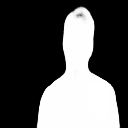

Epoch : 1531/2000
Model Loss(Batch: 0): [0.01504066027700901, 0.9885912537574768]
Epoch : 1532/2000
Model Loss(Batch: 0): [0.014865855686366558, 0.9886760711669922]
Epoch : 1533/2000
Model Loss(Batch: 0): [0.014687001705169678, 0.9887549877166748]
Epoch : 1534/2000
Model Loss(Batch: 0): [0.014622405171394348, 0.9887874126434326]
Epoch : 1535/2000
Model Loss(Batch: 0): [0.014705737121403217, 0.9887377619743347]
Epoch : 1536/2000
Model Loss(Batch: 0): [0.014809509739279747, 0.9886929392814636]
Epoch : 1537/2000
Model Loss(Batch: 0): [0.014691359363496304, 0.9887434244155884]
Epoch : 1538/2000
Model Loss(Batch: 0): [0.01454808097332716, 0.988795816898346]
Epoch : 1539/2000
Model Loss(Batch: 0): [0.01449830923229456, 0.9888301491737366]
Epoch : 1540/2000
Model Loss(Batch: 0): [0.01449191477149725, 0.9888215065002441]


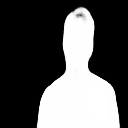

Epoch : 1541/2000
Model Loss(Batch: 0): [0.014529586769640446, 0.9888088703155518]
Epoch : 1542/2000
Model Loss(Batch: 0): [0.014564665034413338, 0.9887701869010925]
Epoch : 1543/2000
Model Loss(Batch: 0): [0.014587922021746635, 0.9887728691101074]
Epoch : 1544/2000
Model Loss(Batch: 0): [0.014526539482176304, 0.9888032078742981]
Epoch : 1545/2000
Model Loss(Batch: 0): [0.014436011202633381, 0.9888375401496887]
Epoch : 1546/2000
Model Loss(Batch: 0): [0.014346244744956493, 0.9888646602630615]
Epoch : 1547/2000
Model Loss(Batch: 0): [0.01430651918053627, 0.9888728857040405]
Epoch : 1548/2000
Model Loss(Batch: 0): [0.014290306717157364, 0.9888831973075867]
Epoch : 1549/2000
Model Loss(Batch: 0): [0.014281608164310455, 0.9888907670974731]
Epoch : 1550/2000
Model Loss(Batch: 0): [0.014289024285972118, 0.988884449005127]


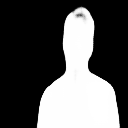

Epoch : 1551/2000
Model Loss(Batch: 0): [0.01431211270391941, 0.9888675808906555]
Epoch : 1552/2000
Model Loss(Batch: 0): [0.014345596544444561, 0.988851010799408]
Epoch : 1553/2000
Model Loss(Batch: 0): [0.014384716749191284, 0.9888309836387634]
Epoch : 1554/2000
Model Loss(Batch: 0): [0.014503641985356808, 0.9887868165969849]
Epoch : 1555/2000
Model Loss(Batch: 0): [0.01476110890507698, 0.9886598587036133]
Epoch : 1556/2000
Model Loss(Batch: 0): [0.015481540933251381, 0.9883458614349365]
Epoch : 1557/2000
Model Loss(Batch: 0): [0.016842065379023552, 0.987788736820221]
Epoch : 1558/2000
Model Loss(Batch: 0): [0.021132923662662506, 0.9861080050468445]
Epoch : 1559/2000
Model Loss(Batch: 0): [0.02629774436354637, 0.9845292568206787]
Epoch : 1560/2000
Model Loss(Batch: 0): [0.04789122939109802, 0.9786677956581116]


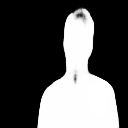

Epoch : 1561/2000
Model Loss(Batch: 0): [0.03904591500759125, 0.9816109538078308]
Epoch : 1562/2000
Model Loss(Batch: 0): [0.034741565585136414, 0.9818453788757324]
Epoch : 1563/2000
Model Loss(Batch: 0): [0.020912442356348038, 0.9863211512565613]
Epoch : 1564/2000
Model Loss(Batch: 0): [0.03042021207511425, 0.9834238886833191]
Epoch : 1565/2000
Model Loss(Batch: 0): [0.020940162241458893, 0.9862298369407654]
Epoch : 1566/2000
Model Loss(Batch: 0): [0.023306461051106453, 0.9853839874267578]
Epoch : 1567/2000
Model Loss(Batch: 0): [0.023267677053809166, 0.9855287671089172]
Epoch : 1568/2000
Model Loss(Batch: 0): [0.019554713740944862, 0.9869584441184998]
Epoch : 1569/2000
Model Loss(Batch: 0): [0.02313220128417015, 0.9854696393013]
Epoch : 1570/2000
Model Loss(Batch: 0): [0.019618643447756767, 0.9869601726531982]


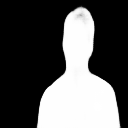

Epoch : 1571/2000
Model Loss(Batch: 0): [0.020383521914482117, 0.9867296814918518]
Epoch : 1572/2000
Model Loss(Batch: 0): [0.02039180137217045, 0.9867223501205444]
Epoch : 1573/2000
Model Loss(Batch: 0): [0.019695306196808815, 0.9870209693908691]
Epoch : 1574/2000
Model Loss(Batch: 0): [0.018623262643814087, 0.987530529499054]
Epoch : 1575/2000
Model Loss(Batch: 0): [0.019477909430861473, 0.9870296120643616]
Epoch : 1576/2000
Model Loss(Batch: 0): [0.018709074705839157, 0.9873396158218384]
Epoch : 1577/2000
Model Loss(Batch: 0): [0.017754772678017616, 0.9878618121147156]
Epoch : 1578/2000
Model Loss(Batch: 0): [0.018545517697930336, 0.9874858856201172]
Epoch : 1579/2000
Model Loss(Batch: 0): [0.017677782103419304, 0.9878354668617249]
Epoch : 1580/2000
Model Loss(Batch: 0): [0.017420930787920952, 0.9878821969032288]


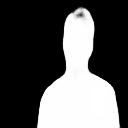

Epoch : 1581/2000
Model Loss(Batch: 0): [0.017265688627958298, 0.9879377484321594]
Epoch : 1582/2000
Model Loss(Batch: 0): [0.017170913517475128, 0.9879440665245056]
Epoch : 1583/2000
Model Loss(Batch: 0): [0.01671679876744747, 0.9881210923194885]
Epoch : 1584/2000
Model Loss(Batch: 0): [0.016494175419211388, 0.9882223010063171]
Epoch : 1585/2000
Model Loss(Batch: 0): [0.01667194999754429, 0.9881097078323364]
Epoch : 1586/2000
Model Loss(Batch: 0): [0.01607380248606205, 0.9883736371994019]
Epoch : 1587/2000
Model Loss(Batch: 0): [0.015992531552910805, 0.9883648157119751]
Epoch : 1588/2000
Model Loss(Batch: 0): [0.01612018421292305, 0.988292396068573]
Epoch : 1589/2000
Model Loss(Batch: 0): [0.015583259053528309, 0.988510251045227]
Epoch : 1590/2000
Model Loss(Batch: 0): [0.015637479722499847, 0.9884658455848694]


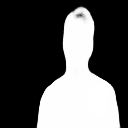

Epoch : 1591/2000
Model Loss(Batch: 0): [0.015582875348627567, 0.9884811639785767]
Epoch : 1592/2000
Model Loss(Batch: 0): [0.01530133280903101, 0.988598644733429]
Epoch : 1593/2000
Model Loss(Batch: 0): [0.015269719995558262, 0.9885674715042114]
Epoch : 1594/2000
Model Loss(Batch: 0): [0.01523169782012701, 0.9885828495025635]
Epoch : 1595/2000
Model Loss(Batch: 0): [0.015014871954917908, 0.9886899590492249]
Epoch : 1596/2000
Model Loss(Batch: 0): [0.014949170872569084, 0.9886826276779175]
Epoch : 1597/2000
Model Loss(Batch: 0): [0.014988529495894909, 0.988662600517273]
Epoch : 1598/2000
Model Loss(Batch: 0): [0.014783704653382301, 0.9887476563453674]
Epoch : 1599/2000
Model Loss(Batch: 0): [0.014724073931574821, 0.9887621402740479]
Epoch : 1600/2000
Model Loss(Batch: 0): [0.014750944450497627, 0.9887247085571289]


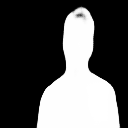

Epoch : 1601/2000
Model Loss(Batch: 0): [0.014636164531111717, 0.9887722730636597]
Epoch : 1602/2000
Model Loss(Batch: 0): [0.014553122222423553, 0.9888145923614502]
Epoch : 1603/2000
Model Loss(Batch: 0): [0.014525157399475574, 0.9888213276863098]
Epoch : 1604/2000
Model Loss(Batch: 0): [0.01447583269327879, 0.9888261556625366]
Epoch : 1605/2000
Model Loss(Batch: 0): [0.014453730545938015, 0.9888231754302979]
Epoch : 1606/2000
Model Loss(Batch: 0): [0.014393516816198826, 0.9888615012168884]
Epoch : 1607/2000
Model Loss(Batch: 0): [0.014312881976366043, 0.9888810515403748]
Epoch : 1608/2000
Model Loss(Batch: 0): [0.014302266761660576, 0.9888737201690674]
Epoch : 1609/2000
Model Loss(Batch: 0): [0.014272906817495823, 0.9888947606086731]
Epoch : 1610/2000
Model Loss(Batch: 0): [0.014245894737541676, 0.9888930916786194]


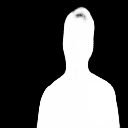

Epoch : 1611/2000
Model Loss(Batch: 0): [0.01422002911567688, 0.9889101386070251]
Epoch : 1612/2000
Model Loss(Batch: 0): [0.014165072701871395, 0.9889143109321594]
Epoch : 1613/2000
Model Loss(Batch: 0): [0.014123362489044666, 0.9889416694641113]
Epoch : 1614/2000
Model Loss(Batch: 0): [0.014096307568252087, 0.9889482259750366]
Epoch : 1615/2000
Model Loss(Batch: 0): [0.014058510772883892, 0.9889610409736633]
Epoch : 1616/2000
Model Loss(Batch: 0): [0.014044800773262978, 0.9889663457870483]
Epoch : 1617/2000
Model Loss(Batch: 0): [0.014026015065610409, 0.9889658689498901]
Epoch : 1618/2000
Model Loss(Batch: 0): [0.014012223109602928, 0.9889816641807556]
Epoch : 1619/2000
Model Loss(Batch: 0): [0.014004863798618317, 0.9889633655548096]
Epoch : 1620/2000
Model Loss(Batch: 0): [0.014008212834596634, 0.9889711737632751]


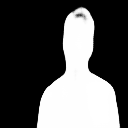

Epoch : 1621/2000
Model Loss(Batch: 0): [0.014029234647750854, 0.9889589548110962]
Epoch : 1622/2000
Model Loss(Batch: 0): [0.014091641642153263, 0.988934338092804]
Epoch : 1623/2000
Model Loss(Batch: 0): [0.014227143488824368, 0.9888536930084229]
Epoch : 1624/2000
Model Loss(Batch: 0): [0.014551622793078423, 0.9887148141860962]
Epoch : 1625/2000
Model Loss(Batch: 0): [0.015118345618247986, 0.9884841442108154]
Epoch : 1626/2000
Model Loss(Batch: 0): [0.016570761799812317, 0.9878769516944885]
Epoch : 1627/2000
Model Loss(Batch: 0): [0.018572429195046425, 0.9871413707733154]
Epoch : 1628/2000
Model Loss(Batch: 0): [0.023484963923692703, 0.9853574633598328]
Epoch : 1629/2000
Model Loss(Batch: 0): [0.024483278393745422, 0.9851552248001099]
Epoch : 1630/2000
Model Loss(Batch: 0): [0.02440052293241024, 0.9850049018859863]


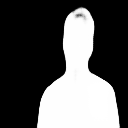

Epoch : 1631/2000
Model Loss(Batch: 0): [0.015914157032966614, 0.9882153868675232]
Epoch : 1632/2000
Model Loss(Batch: 0): [0.016236988827586174, 0.9881067872047424]
Epoch : 1633/2000
Model Loss(Batch: 0): [0.02082936279475689, 0.9862146973609924]
Epoch : 1634/2000
Model Loss(Batch: 0): [0.01574360765516758, 0.9882919788360596]
Epoch : 1635/2000
Model Loss(Batch: 0): [0.015911320224404335, 0.9882530570030212]
Epoch : 1636/2000
Model Loss(Batch: 0): [0.018565870821475983, 0.9870590567588806]
Epoch : 1637/2000
Model Loss(Batch: 0): [0.014597211964428425, 0.9887930750846863]
Epoch : 1638/2000
Model Loss(Batch: 0): [0.016863016411662102, 0.9878148436546326]
Epoch : 1639/2000
Model Loss(Batch: 0): [0.017009541392326355, 0.987690269947052]
Epoch : 1640/2000
Model Loss(Batch: 0): [0.01453745923936367, 0.9888128638267517]


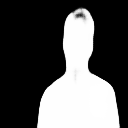

Epoch : 1641/2000
Model Loss(Batch: 0): [0.017365824431180954, 0.9875761866569519]
Epoch : 1642/2000
Model Loss(Batch: 0): [0.015508857555687428, 0.9883538484573364]
Epoch : 1643/2000
Model Loss(Batch: 0): [0.015092366375029087, 0.9885430932044983]
Epoch : 1644/2000
Model Loss(Batch: 0): [0.01659190095961094, 0.9879363179206848]
Epoch : 1645/2000
Model Loss(Batch: 0): [0.014342808164656162, 0.9889021515846252]
Epoch : 1646/2000
Model Loss(Batch: 0): [0.01545788999646902, 0.9883736371994019]
Epoch : 1647/2000
Model Loss(Batch: 0): [0.015138422138988972, 0.9885483384132385]
Epoch : 1648/2000
Model Loss(Batch: 0): [0.014213114976882935, 0.9889448285102844]
Epoch : 1649/2000
Model Loss(Batch: 0): [0.015261824242770672, 0.9884405732154846]
Epoch : 1650/2000
Model Loss(Batch: 0): [0.014232845976948738, 0.9889193773269653]


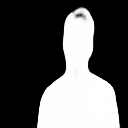

Epoch : 1651/2000
Model Loss(Batch: 0): [0.01447293721139431, 0.9888036251068115]
Epoch : 1652/2000
Model Loss(Batch: 0): [0.014787551946938038, 0.9886441230773926]
Epoch : 1653/2000
Model Loss(Batch: 0): [0.01394940260797739, 0.9890252351760864]
Epoch : 1654/2000
Model Loss(Batch: 0): [0.01453679520636797, 0.9887659549713135]
Epoch : 1655/2000
Model Loss(Batch: 0): [0.014385689981281757, 0.9887922406196594]
Epoch : 1656/2000
Model Loss(Batch: 0): [0.01388593576848507, 0.9890338778495789]
Epoch : 1657/2000
Model Loss(Batch: 0): [0.014382267370820045, 0.9888061285018921]
Epoch : 1658/2000
Model Loss(Batch: 0): [0.01418391615152359, 0.9888623356819153]
Epoch : 1659/2000
Model Loss(Batch: 0): [0.013796151615679264, 0.9890528321266174]
Epoch : 1660/2000
Model Loss(Batch: 0): [0.014179925434291363, 0.9888577461242676]


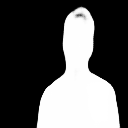

Epoch : 1661/2000
Model Loss(Batch: 0): [0.014102259650826454, 0.9888787865638733]
Epoch : 1662/2000
Model Loss(Batch: 0): [0.013698086142539978, 0.9890774488449097]
Epoch : 1663/2000
Model Loss(Batch: 0): [0.013949675485491753, 0.9889452457427979]
Epoch : 1664/2000
Model Loss(Batch: 0): [0.014067411422729492, 0.9888901114463806]
Epoch : 1665/2000
Model Loss(Batch: 0): [0.013643886893987656, 0.9890803694725037]
Epoch : 1666/2000
Model Loss(Batch: 0): [0.013706128112971783, 0.9890456795692444]
Epoch : 1667/2000
Model Loss(Batch: 0): [0.013945083133876324, 0.9889335036277771]
Epoch : 1668/2000
Model Loss(Batch: 0): [0.013681385666131973, 0.989044189453125]
Epoch : 1669/2000
Model Loss(Batch: 0): [0.013507761992514133, 0.9891199469566345]
Epoch : 1670/2000
Model Loss(Batch: 0): [0.013695080764591694, 0.9890332221984863]


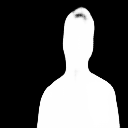

Epoch : 1671/2000
Model Loss(Batch: 0): [0.013705831952393055, 0.9890145063400269]
Epoch : 1672/2000
Model Loss(Batch: 0): [0.013502397574484348, 0.9891144633293152]
Epoch : 1673/2000
Model Loss(Batch: 0): [0.013446635566651821, 0.9891353249549866]
Epoch : 1674/2000
Model Loss(Batch: 0): [0.013561096973717213, 0.9890744686126709]
Epoch : 1675/2000
Model Loss(Batch: 0): [0.013580785132944584, 0.98907870054245]
Epoch : 1676/2000
Model Loss(Batch: 0): [0.013436307199299335, 0.9891313314437866]
Epoch : 1677/2000
Model Loss(Batch: 0): [0.013376967050135136, 0.9891626834869385]
Epoch : 1678/2000
Model Loss(Batch: 0): [0.013430128805339336, 0.9891350865364075]
Epoch : 1679/2000
Model Loss(Batch: 0): [0.01345245074480772, 0.9891126155853271]
Epoch : 1680/2000
Model Loss(Batch: 0): [0.013413217850029469, 0.9891405701637268]


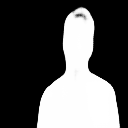

Epoch : 1681/2000
Model Loss(Batch: 0): [0.013340196572244167, 0.9891721606254578]
Epoch : 1682/2000
Model Loss(Batch: 0): [0.01330526266247034, 0.9891847968101501]
Epoch : 1683/2000
Model Loss(Batch: 0): [0.013316556811332703, 0.9891808032989502]
Epoch : 1684/2000
Model Loss(Batch: 0): [0.01333905290812254, 0.989155113697052]
Epoch : 1685/2000
Model Loss(Batch: 0): [0.013336235657334328, 0.9891650080680847]
Epoch : 1686/2000
Model Loss(Batch: 0): [0.013287832960486412, 0.9891790747642517]
Epoch : 1687/2000
Model Loss(Batch: 0): [0.013234470970928669, 0.9892055988311768]
Epoch : 1688/2000
Model Loss(Batch: 0): [0.013209514319896698, 0.9892180562019348]
Epoch : 1689/2000
Model Loss(Batch: 0): [0.013218194246292114, 0.9892020225524902]
Epoch : 1690/2000
Model Loss(Batch: 0): [0.013235071673989296, 0.98919677734375]


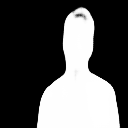

Epoch : 1691/2000
Model Loss(Batch: 0): [0.013231592252850533, 0.9891932010650635]
Epoch : 1692/2000
Model Loss(Batch: 0): [0.013214034959673882, 0.9892037510871887]
Epoch : 1693/2000
Model Loss(Batch: 0): [0.013188584707677364, 0.9892011880874634]
Epoch : 1694/2000
Model Loss(Batch: 0): [0.013165806420147419, 0.9892256259918213]
Epoch : 1695/2000
Model Loss(Batch: 0): [0.013142581097781658, 0.9892336130142212]
Epoch : 1696/2000
Model Loss(Batch: 0): [0.013119579292833805, 0.9892430901527405]
Epoch : 1697/2000
Model Loss(Batch: 0): [0.01309943851083517, 0.989245593547821]
Epoch : 1698/2000
Model Loss(Batch: 0): [0.013085712678730488, 0.9892502427101135]
Epoch : 1699/2000
Model Loss(Batch: 0): [0.013078802265226841, 0.9892502427101135]
Epoch : 1700/2000
Model Loss(Batch: 0): [0.01307615451514721, 0.9892504215240479]


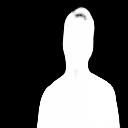

Epoch : 1701/2000
Model Loss(Batch: 0): [0.013076343573629856, 0.989249587059021]
Epoch : 1702/2000
Model Loss(Batch: 0): [0.013078831136226654, 0.9892390966415405]
Epoch : 1703/2000
Model Loss(Batch: 0): [0.013090445660054684, 0.9892386794090271]
Epoch : 1704/2000
Model Loss(Batch: 0): [0.013118010945618153, 0.9892142415046692]
Epoch : 1705/2000
Model Loss(Batch: 0): [0.013187906704843044, 0.9891915321350098]
Epoch : 1706/2000
Model Loss(Batch: 0): [0.013316407799720764, 0.9891182780265808]
Epoch : 1707/2000
Model Loss(Batch: 0): [0.013616272248327732, 0.9889955520629883]
Epoch : 1708/2000
Model Loss(Batch: 0): [0.014105234295129776, 0.9888015389442444]
Epoch : 1709/2000
Model Loss(Batch: 0): [0.015305712819099426, 0.9882911443710327]
Epoch : 1710/2000
Model Loss(Batch: 0): [0.016770243644714355, 0.9877891540527344]


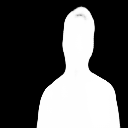

Epoch : 1711/2000
Model Loss(Batch: 0): [0.020425383001565933, 0.9864009618759155]
Epoch : 1712/2000
Model Loss(Batch: 0): [0.02144801989197731, 0.9861553311347961]
Epoch : 1713/2000
Model Loss(Batch: 0): [0.023253871127963066, 0.9854037761688232]
Epoch : 1714/2000
Model Loss(Batch: 0): [0.01710226573050022, 0.987743079662323]
Epoch : 1715/2000
Model Loss(Batch: 0): [0.01357137132436037, 0.9890521764755249]
Epoch : 1716/2000
Model Loss(Batch: 0): [0.016041196882724762, 0.9880430102348328]
Epoch : 1717/2000
Model Loss(Batch: 0): [0.01684066466987133, 0.9877977967262268]
Epoch : 1718/2000
Model Loss(Batch: 0): [0.014256985858082771, 0.9887688755989075]
Epoch : 1719/2000
Model Loss(Batch: 0): [0.014060119166970253, 0.9888918399810791]
Epoch : 1720/2000
Model Loss(Batch: 0): [0.015594623982906342, 0.9882587194442749]


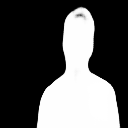

Epoch : 1721/2000
Model Loss(Batch: 0): [0.014468873851001263, 0.9886638522148132]
Epoch : 1722/2000
Model Loss(Batch: 0): [0.013785076327621937, 0.9889974594116211]
Epoch : 1723/2000
Model Loss(Batch: 0): [0.014727802947163582, 0.9886030554771423]
Epoch : 1724/2000
Model Loss(Batch: 0): [0.014336518943309784, 0.9887381792068481]
Epoch : 1725/2000
Model Loss(Batch: 0): [0.013756638392806053, 0.9890029430389404]
Epoch : 1726/2000
Model Loss(Batch: 0): [0.014240679331123829, 0.9888099431991577]
Epoch : 1727/2000
Model Loss(Batch: 0): [0.013981245458126068, 0.9888827800750732]
Epoch : 1728/2000
Model Loss(Batch: 0): [0.013777648098766804, 0.9889705181121826]
Epoch : 1729/2000
Model Loss(Batch: 0): [0.013800187036395073, 0.988963782787323]
Epoch : 1730/2000
Model Loss(Batch: 0): [0.013637957163155079, 0.9890227317810059]


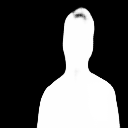

Epoch : 1731/2000
Model Loss(Batch: 0): [0.013738170266151428, 0.9889755845069885]
Epoch : 1732/2000
Model Loss(Batch: 0): [0.013417421840131283, 0.9891243577003479]
Epoch : 1733/2000
Model Loss(Batch: 0): [0.013350965455174446, 0.9891559481620789]
Epoch : 1734/2000
Model Loss(Batch: 0): [0.013589512556791306, 0.9890239834785461]
Epoch : 1735/2000
Model Loss(Batch: 0): [0.01328603271394968, 0.989155113697052]
Epoch : 1736/2000
Model Loss(Batch: 0): [0.0131205590441823, 0.989242672920227]
Epoch : 1737/2000
Model Loss(Batch: 0): [0.01335550844669342, 0.9891270995140076]
Epoch : 1738/2000
Model Loss(Batch: 0): [0.013253736309707165, 0.9891654253005981]
Epoch : 1739/2000
Model Loss(Batch: 0): [0.013017181307077408, 0.9892717003822327]
Epoch : 1740/2000
Model Loss(Batch: 0): [0.013132269494235516, 0.9892055988311768]


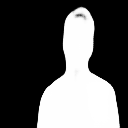

Epoch : 1741/2000
Model Loss(Batch: 0): [0.013116464950144291, 0.989223062992096]
Epoch : 1742/2000
Model Loss(Batch: 0): [0.013006818480789661, 0.9892609715461731]
Epoch : 1743/2000
Model Loss(Batch: 0): [0.013046417385339737, 0.9892336130142212]
Epoch : 1744/2000
Model Loss(Batch: 0): [0.012937547639012337, 0.989289402961731]
Epoch : 1745/2000
Model Loss(Batch: 0): [0.012876586057245731, 0.9892942309379578]
Epoch : 1746/2000
Model Loss(Batch: 0): [0.012971639633178711, 0.989256739616394]
Epoch : 1747/2000
Model Loss(Batch: 0): [0.012939151376485825, 0.9892744421958923]
Epoch : 1748/2000
Model Loss(Batch: 0): [0.012837957590818405, 0.9893165230751038]
Epoch : 1749/2000
Model Loss(Batch: 0): [0.01280446071177721, 0.9893268346786499]
Epoch : 1750/2000
Model Loss(Batch: 0): [0.012812672182917595, 0.9893253445625305]


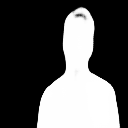

Epoch : 1751/2000
Model Loss(Batch: 0): [0.012801424600183964, 0.9893186092376709]
Epoch : 1752/2000
Model Loss(Batch: 0): [0.012781059369444847, 0.9893247485160828]
Epoch : 1753/2000
Model Loss(Batch: 0): [0.012799294665455818, 0.9893239140510559]
Epoch : 1754/2000
Model Loss(Batch: 0): [0.01280535850673914, 0.9893013834953308]
Epoch : 1755/2000
Model Loss(Batch: 0): [0.012763924896717072, 0.989337146282196]
Epoch : 1756/2000
Model Loss(Batch: 0): [0.012717971578240395, 0.9893390536308289]
Epoch : 1757/2000
Model Loss(Batch: 0): [0.01271266583353281, 0.9893462061882019]
Epoch : 1758/2000
Model Loss(Batch: 0): [0.01270289160311222, 0.9893552660942078]
Epoch : 1759/2000
Model Loss(Batch: 0): [0.012674033641815186, 0.9893636703491211]
Epoch : 1760/2000
Model Loss(Batch: 0): [0.012643508613109589, 0.9893620014190674]


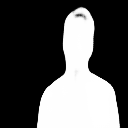

Epoch : 1761/2000
Model Loss(Batch: 0): [0.012634898535907269, 0.9893729090690613]
Epoch : 1762/2000
Model Loss(Batch: 0): [0.012634889222681522, 0.9893679022789001]
Epoch : 1763/2000
Model Loss(Batch: 0): [0.012634496204555035, 0.989368736743927]
Epoch : 1764/2000
Model Loss(Batch: 0): [0.012631789781153202, 0.9893738031387329]
Epoch : 1765/2000
Model Loss(Batch: 0): [0.012652618810534477, 0.9893607497215271]
Epoch : 1766/2000
Model Loss(Batch: 0): [0.012720423750579357, 0.9893274903297424]
Epoch : 1767/2000
Model Loss(Batch: 0): [0.012920551933348179, 0.9892445802688599]
Epoch : 1768/2000
Model Loss(Batch: 0): [0.013331773690879345, 0.9890785217285156]
Epoch : 1769/2000
Model Loss(Batch: 0): [0.014507586136460304, 0.9885952472686768]
Epoch : 1770/2000
Model Loss(Batch: 0): [0.016520747914910316, 0.9878933429718018]


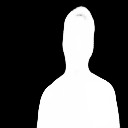

Epoch : 1771/2000
Model Loss(Batch: 0): [0.023253463208675385, 0.9857180118560791]
Epoch : 1772/2000
Model Loss(Batch: 0): [0.025714293122291565, 0.9851455092430115]
Epoch : 1773/2000
Model Loss(Batch: 0): [0.03269631788134575, 0.9829779267311096]
Epoch : 1774/2000
Model Loss(Batch: 0): [0.019816312938928604, 0.9868687987327576]
Epoch : 1775/2000
Model Loss(Batch: 0): [0.019605476409196854, 0.9869475364685059]
Epoch : 1776/2000
Model Loss(Batch: 0): [0.022729920223355293, 0.9858438372612]
Epoch : 1777/2000
Model Loss(Batch: 0): [0.017437592148780823, 0.9875896573066711]
Epoch : 1778/2000
Model Loss(Batch: 0): [0.022289015352725983, 0.9860360026359558]
Epoch : 1779/2000
Model Loss(Batch: 0): [0.01620505191385746, 0.9880122542381287]
Epoch : 1780/2000
Model Loss(Batch: 0): [0.020936472341418266, 0.9863333702087402]


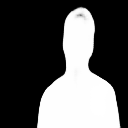

Epoch : 1781/2000
Model Loss(Batch: 0): [0.015619372949004173, 0.9883174300193787]
Epoch : 1782/2000
Model Loss(Batch: 0): [0.019163213670253754, 0.9869736433029175]
Epoch : 1783/2000
Model Loss(Batch: 0): [0.015144792385399342, 0.988558828830719]
Epoch : 1784/2000
Model Loss(Batch: 0): [0.017610859125852585, 0.9875187277793884]
Epoch : 1785/2000
Model Loss(Batch: 0): [0.015947753563523293, 0.988205075263977]
Epoch : 1786/2000
Model Loss(Batch: 0): [0.015647249296307564, 0.9883963465690613]
Epoch : 1787/2000
Model Loss(Batch: 0): [0.016349220648407936, 0.9881139397621155]
Epoch : 1788/2000
Model Loss(Batch: 0): [0.014874550513923168, 0.9886844754219055]
Epoch : 1789/2000
Model Loss(Batch: 0): [0.0157829187810421, 0.9882766008377075]
Epoch : 1790/2000
Model Loss(Batch: 0): [0.014911950565874577, 0.9886602759361267]


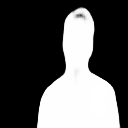

Epoch : 1791/2000
Model Loss(Batch: 0): [0.014713744632899761, 0.9887354373931885]
Epoch : 1792/2000
Model Loss(Batch: 0): [0.015114851295948029, 0.988514244556427]
Epoch : 1793/2000
Model Loss(Batch: 0): [0.014150737784802914, 0.9889269471168518]
Epoch : 1794/2000
Model Loss(Batch: 0): [0.01458829641342163, 0.9887065887451172]
Epoch : 1795/2000
Model Loss(Batch: 0): [0.0142842847853899, 0.9888303279876709]
Epoch : 1796/2000
Model Loss(Batch: 0): [0.013898991048336029, 0.9890046119689941]
Epoch : 1797/2000
Model Loss(Batch: 0): [0.014171014539897442, 0.9888903498649597]
Epoch : 1798/2000
Model Loss(Batch: 0): [0.013739068061113358, 0.9890303015708923]
Epoch : 1799/2000
Model Loss(Batch: 0): [0.013688182458281517, 0.9890403747558594]
Epoch : 1800/2000
Model Loss(Batch: 0): [0.013764779083430767, 0.988986074924469]


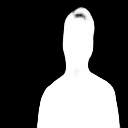

Epoch : 1801/2000
Model Loss(Batch: 0): [0.013383408077061176, 0.9891519546508789]
Epoch : 1802/2000
Model Loss(Batch: 0): [0.013509159907698631, 0.9890850186347961]
Epoch : 1803/2000
Model Loss(Batch: 0): [0.013323450461030006, 0.989166259765625]
Epoch : 1804/2000
Model Loss(Batch: 0): [0.013256906531751156, 0.9891670942306519]
Epoch : 1805/2000
Model Loss(Batch: 0): [0.013230214826762676, 0.9891729950904846]
Epoch : 1806/2000
Model Loss(Batch: 0): [0.013091598637402058, 0.9892414212226868]
Epoch : 1807/2000
Model Loss(Batch: 0): [0.01310914009809494, 0.9892114996910095]
Epoch : 1808/2000
Model Loss(Batch: 0): [0.01296259742230177, 0.9892632961273193]
Epoch : 1809/2000
Model Loss(Batch: 0): [0.012964555062353611, 0.9892784357070923]
Epoch : 1810/2000
Model Loss(Batch: 0): [0.01292853057384491, 0.989281177520752]


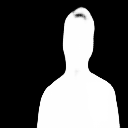

Epoch : 1811/2000
Model Loss(Batch: 0): [0.012809280306100845, 0.9893234968185425]
Epoch : 1812/2000
Model Loss(Batch: 0): [0.012833300977945328, 0.9892933964729309]
Epoch : 1813/2000
Model Loss(Batch: 0): [0.012770055793225765, 0.9893220067024231]
Epoch : 1814/2000
Model Loss(Batch: 0): [0.012738271616399288, 0.989334225654602]
Epoch : 1815/2000
Model Loss(Batch: 0): [0.012696398422122002, 0.9893540143966675]
Epoch : 1816/2000
Model Loss(Batch: 0): [0.01262461207807064, 0.9893723130226135]
Epoch : 1817/2000
Model Loss(Batch: 0): [0.012660660780966282, 0.9893438816070557]
Epoch : 1818/2000
Model Loss(Batch: 0): [0.012605196796357632, 0.9893777966499329]
Epoch : 1819/2000
Model Loss(Batch: 0): [0.012563460506498814, 0.9893887042999268]
Epoch : 1820/2000
Model Loss(Batch: 0): [0.012546557001769543, 0.9893996715545654]


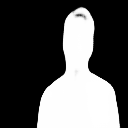

Epoch : 1821/2000
Model Loss(Batch: 0): [0.0124965263530612, 0.989411473274231]
Epoch : 1822/2000
Model Loss(Batch: 0): [0.012516725808382034, 0.989392101764679]
Epoch : 1823/2000
Model Loss(Batch: 0): [0.012472583912312984, 0.9894152283668518]
Epoch : 1824/2000
Model Loss(Batch: 0): [0.012479127384722233, 0.9894171357154846]
Epoch : 1825/2000
Model Loss(Batch: 0): [0.012427710928022861, 0.989437997341156]
Epoch : 1826/2000
Model Loss(Batch: 0): [0.012414384633302689, 0.9894281029701233]
Epoch : 1827/2000
Model Loss(Batch: 0): [0.012387417256832123, 0.9894483089447021]
Epoch : 1828/2000
Model Loss(Batch: 0): [0.012369220145046711, 0.989453136920929]
Epoch : 1829/2000
Model Loss(Batch: 0): [0.012361704371869564, 0.9894484877586365]
Epoch : 1830/2000
Model Loss(Batch: 0): [0.012345035560429096, 0.9894455671310425]


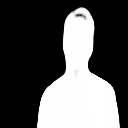

Epoch : 1831/2000
Model Loss(Batch: 0): [0.01234605722129345, 0.9894575476646423]
Epoch : 1832/2000
Model Loss(Batch: 0): [0.012325038202106953, 0.989459216594696]
Epoch : 1833/2000
Model Loss(Batch: 0): [0.012329737655818462, 0.9894634485244751]
Epoch : 1834/2000
Model Loss(Batch: 0): [0.012310790829360485, 0.9894567131996155]
Epoch : 1835/2000
Model Loss(Batch: 0): [0.01232409942895174, 0.9894617795944214]
Epoch : 1836/2000
Model Loss(Batch: 0): [0.012324413284659386, 0.9894459843635559]
Epoch : 1837/2000
Model Loss(Batch: 0): [0.012357075698673725, 0.9894318580627441]
Epoch : 1838/2000
Model Loss(Batch: 0): [0.012411047704517841, 0.9894173741340637]
Epoch : 1839/2000
Model Loss(Batch: 0): [0.01252896897494793, 0.9893624186515808]
Epoch : 1840/2000
Model Loss(Batch: 0): [0.0127850491553545, 0.9892491698265076]


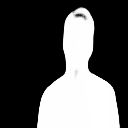

Epoch : 1841/2000
Model Loss(Batch: 0): [0.013191535137593746, 0.9890875220298767]
Epoch : 1842/2000
Model Loss(Batch: 0): [0.014178608544170856, 0.9887064099311829]
Epoch : 1843/2000
Model Loss(Batch: 0): [0.015401541255414486, 0.9882644414901733]
Epoch : 1844/2000
Model Loss(Batch: 0): [0.018473530188202858, 0.9870998859405518]
Epoch : 1845/2000
Model Loss(Batch: 0): [0.019576875492930412, 0.986845850944519]
Epoch : 1846/2000
Model Loss(Batch: 0): [0.02154778130352497, 0.9860424995422363]
Epoch : 1847/2000
Model Loss(Batch: 0): [0.016214244067668915, 0.9880356192588806]
Epoch : 1848/2000
Model Loss(Batch: 0): [0.013012131676077843, 0.9892032742500305]
Epoch : 1849/2000
Model Loss(Batch: 0): [0.014399193227291107, 0.9886333346366882]
Epoch : 1850/2000
Model Loss(Batch: 0): [0.015426001511514187, 0.988296627998352]


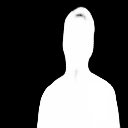

Epoch : 1851/2000
Model Loss(Batch: 0): [0.014529264532029629, 0.9886104464530945]
Epoch : 1852/2000
Model Loss(Batch: 0): [0.012974382378160954, 0.9892127513885498]
Epoch : 1853/2000
Model Loss(Batch: 0): [0.014112676493823528, 0.9887996315956116]
Epoch : 1854/2000
Model Loss(Batch: 0): [0.01482933759689331, 0.988491952419281]
Epoch : 1855/2000
Model Loss(Batch: 0): [0.0127208037301898, 0.989337146282196]
Epoch : 1856/2000
Model Loss(Batch: 0): [0.013663275167346, 0.988967776298523]
Epoch : 1857/2000
Model Loss(Batch: 0): [0.014339851215481758, 0.9886670112609863]
Epoch : 1858/2000
Model Loss(Batch: 0): [0.01273202896118164, 0.9893291592597961]
Epoch : 1859/2000
Model Loss(Batch: 0): [0.013521787710487843, 0.9890282154083252]
Epoch : 1860/2000
Model Loss(Batch: 0): [0.013708652928471565, 0.9889078140258789]


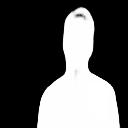

Epoch : 1861/2000
Model Loss(Batch: 0): [0.012995187193155289, 0.9892109036445618]
Epoch : 1862/2000
Model Loss(Batch: 0): [0.013020165264606476, 0.989228367805481]
Epoch : 1863/2000
Model Loss(Batch: 0): [0.013230283744633198, 0.9890910983085632]
Epoch : 1864/2000
Model Loss(Batch: 0): [0.013022895902395248, 0.9892135858535767]
Epoch : 1865/2000
Model Loss(Batch: 0): [0.012519318610429764, 0.9894198775291443]
Epoch : 1866/2000
Model Loss(Batch: 0): [0.012941070832312107, 0.9892109036445618]
Epoch : 1867/2000
Model Loss(Batch: 0): [0.012727223336696625, 0.9893167614936829]
Epoch : 1868/2000
Model Loss(Batch: 0): [0.012409858405590057, 0.9894430041313171]
Epoch : 1869/2000
Model Loss(Batch: 0): [0.012582557275891304, 0.9893516898155212]
Epoch : 1870/2000
Model Loss(Batch: 0): [0.01259627379477024, 0.9893586039543152]


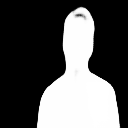

Epoch : 1871/2000
Model Loss(Batch: 0): [0.012428405694663525, 0.989410400390625]
Epoch : 1872/2000
Model Loss(Batch: 0): [0.012278784066438675, 0.9894800782203674]
Epoch : 1873/2000
Model Loss(Batch: 0): [0.012495354749262333, 0.9893966913223267]
Epoch : 1874/2000
Model Loss(Batch: 0): [0.012418028898537159, 0.989395022392273]
Epoch : 1875/2000
Model Loss(Batch: 0): [0.012238923460245132, 0.9894817471504211]
Epoch : 1876/2000
Model Loss(Batch: 0): [0.012231648899614811, 0.989493727684021]
Epoch : 1877/2000
Model Loss(Batch: 0): [0.012279105372726917, 0.9894388318061829]
Epoch : 1878/2000
Model Loss(Batch: 0): [0.012298190966248512, 0.989430844783783]
Epoch : 1879/2000
Model Loss(Batch: 0): [0.012164438143372536, 0.9894912242889404]
Epoch : 1880/2000
Model Loss(Batch: 0): [0.012094493955373764, 0.9895067811012268]


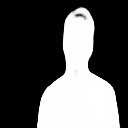

Epoch : 1881/2000
Model Loss(Batch: 0): [0.012119694612920284, 0.9895027875900269]
Epoch : 1882/2000
Model Loss(Batch: 0): [0.012170127592980862, 0.9894861578941345]
Epoch : 1883/2000
Model Loss(Batch: 0): [0.01214289478957653, 0.9894986152648926]
Epoch : 1884/2000
Model Loss(Batch: 0): [0.012049187906086445, 0.9895236492156982]
Epoch : 1885/2000
Model Loss(Batch: 0): [0.012004485353827477, 0.9895606637001038]
Epoch : 1886/2000
Model Loss(Batch: 0): [0.012000205926597118, 0.9895541667938232]
Epoch : 1887/2000
Model Loss(Batch: 0): [0.012023800984025002, 0.9895272254943848]
Epoch : 1888/2000
Model Loss(Batch: 0): [0.012033719569444656, 0.9895358085632324]
Epoch : 1889/2000
Model Loss(Batch: 0): [0.012023561634123325, 0.989528477191925]
Epoch : 1890/2000
Model Loss(Batch: 0): [0.01198672316968441, 0.9895415306091309]


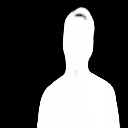

Epoch : 1891/2000
Model Loss(Batch: 0): [0.011933835223317146, 0.9895638227462769]
Epoch : 1892/2000
Model Loss(Batch: 0): [0.011897765100002289, 0.9895819425582886]
Epoch : 1893/2000
Model Loss(Batch: 0): [0.011890999041497707, 0.9895665645599365]
Epoch : 1894/2000
Model Loss(Batch: 0): [0.011880449019372463, 0.9895851016044617]
Epoch : 1895/2000
Model Loss(Batch: 0): [0.0118806017562747, 0.9895842671394348]
Epoch : 1896/2000
Model Loss(Batch: 0): [0.011893760412931442, 0.9895598292350769]
Epoch : 1897/2000
Model Loss(Batch: 0): [0.01190637331455946, 0.9895678162574768]
Epoch : 1898/2000
Model Loss(Batch: 0): [0.011931543238461018, 0.9895537495613098]
Epoch : 1899/2000
Model Loss(Batch: 0): [0.011959521099925041, 0.9895499348640442]
Epoch : 1900/2000
Model Loss(Batch: 0): [0.01202456746250391, 0.9895012974739075]


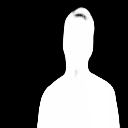

Epoch : 1901/2000
Model Loss(Batch: 0): [0.012118391692638397, 0.9894838333129883]
Epoch : 1902/2000
Model Loss(Batch: 0): [0.01233878917992115, 0.9893792271614075]
Epoch : 1903/2000
Model Loss(Batch: 0): [0.012650294229388237, 0.9892674684524536]
Epoch : 1904/2000
Model Loss(Batch: 0): [0.013396404683589935, 0.9889701008796692]
Epoch : 1905/2000
Model Loss(Batch: 0): [0.014285970479249954, 0.988659679889679]
Epoch : 1906/2000
Model Loss(Batch: 0): [0.016458390280604362, 0.987812340259552]
Epoch : 1907/2000
Model Loss(Batch: 0): [0.017664123326539993, 0.9874821305274963]
Epoch : 1908/2000
Model Loss(Batch: 0): [0.020350689068436623, 0.9864493608474731]
Epoch : 1909/2000
Model Loss(Batch: 0): [0.017619475722312927, 0.9875509142875671]
Epoch : 1910/2000
Model Loss(Batch: 0): [0.014279728755354881, 0.9886541962623596]


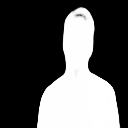

Epoch : 1911/2000
Model Loss(Batch: 0): [0.012112940661609173, 0.9894958734512329]
Epoch : 1912/2000
Model Loss(Batch: 0): [0.014259847812354565, 0.9886992573738098]
Epoch : 1913/2000
Model Loss(Batch: 0): [0.015747902914881706, 0.9880726933479309]
Epoch : 1914/2000
Model Loss(Batch: 0): [0.012970207259058952, 0.989205002784729]
Epoch : 1915/2000
Model Loss(Batch: 0): [0.012553627602756023, 0.9893548488616943]
Epoch : 1916/2000
Model Loss(Batch: 0): [0.014275449328124523, 0.988650381565094]
Epoch : 1917/2000
Model Loss(Batch: 0): [0.013430079445242882, 0.989029049873352]
Epoch : 1918/2000
Model Loss(Batch: 0): [0.012268203310668468, 0.9894444942474365]
Epoch : 1919/2000
Model Loss(Batch: 0): [0.012919716536998749, 0.9891776442527771]
Epoch : 1920/2000
Model Loss(Batch: 0): [0.013202762231230736, 0.9890991449356079]


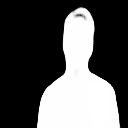

Epoch : 1921/2000
Model Loss(Batch: 0): [0.012357087805867195, 0.9894087314605713]
Epoch : 1922/2000
Model Loss(Batch: 0): [0.01230500265955925, 0.989445149898529]
Epoch : 1923/2000
Model Loss(Batch: 0): [0.012803809717297554, 0.9892575740814209]
Epoch : 1924/2000
Model Loss(Batch: 0): [0.01251901313662529, 0.9893323183059692]
Epoch : 1925/2000
Model Loss(Batch: 0): [0.012034819461405277, 0.9895524382591248]
Epoch : 1926/2000
Model Loss(Batch: 0): [0.012421270832419395, 0.989402174949646]
Epoch : 1927/2000
Model Loss(Batch: 0): [0.01251218281686306, 0.989337146282196]
Epoch : 1928/2000
Model Loss(Batch: 0): [0.011987823061645031, 0.9895516037940979]
Epoch : 1929/2000
Model Loss(Batch: 0): [0.012085775844752789, 0.9895196557044983]
Epoch : 1930/2000
Model Loss(Batch: 0): [0.012296605855226517, 0.989420473575592]


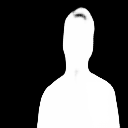

Epoch : 1931/2000
Model Loss(Batch: 0): [0.012118328362703323, 0.9895021915435791]
Epoch : 1932/2000
Model Loss(Batch: 0): [0.01187203824520111, 0.9896019101142883]
Epoch : 1933/2000
Model Loss(Batch: 0): [0.011944924481213093, 0.9895585775375366]
Epoch : 1934/2000
Model Loss(Batch: 0): [0.012118592858314514, 0.9894876480102539]
Epoch : 1935/2000
Model Loss(Batch: 0): [0.011942939832806587, 0.989540696144104]
Epoch : 1936/2000
Model Loss(Batch: 0): [0.011779994703829288, 0.9896263480186462]
Epoch : 1937/2000
Model Loss(Batch: 0): [0.011823906563222408, 0.9895960092544556]
Epoch : 1938/2000
Model Loss(Batch: 0): [0.011904994957149029, 0.9895385503768921]
Epoch : 1939/2000
Model Loss(Batch: 0): [0.011891298927366734, 0.9895617365837097]
Epoch : 1940/2000
Model Loss(Batch: 0): [0.01175902783870697, 0.9895985722541809]


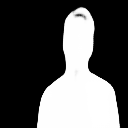

Epoch : 1941/2000
Model Loss(Batch: 0): [0.011680955067276955, 0.9896347522735596]
Epoch : 1942/2000
Model Loss(Batch: 0): [0.011715543456375599, 0.9896347522735596]
Epoch : 1943/2000
Model Loss(Batch: 0): [0.011769859120249748, 0.9895890951156616]
Epoch : 1944/2000
Model Loss(Batch: 0): [0.011770276352763176, 0.9896000027656555]
Epoch : 1945/2000
Model Loss(Batch: 0): [0.011712462641298771, 0.9896152019500732]
Epoch : 1946/2000
Model Loss(Batch: 0): [0.011635657399892807, 0.989650309085846]
Epoch : 1947/2000
Model Loss(Batch: 0): [0.011603295803070068, 0.9896520376205444]
Epoch : 1948/2000
Model Loss(Batch: 0): [0.011593285016715527, 0.9896641969680786]
Epoch : 1949/2000
Model Loss(Batch: 0): [0.011605407111346722, 0.9896560311317444]
Epoch : 1950/2000
Model Loss(Batch: 0): [0.011637303046882153, 0.9896303415298462]


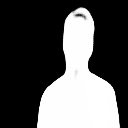

Epoch : 1951/2000
Model Loss(Batch: 0): [0.011658902280032635, 0.9896295070648193]
Epoch : 1952/2000
Model Loss(Batch: 0): [0.011676781810820103, 0.9896160364151001]
Epoch : 1953/2000
Model Loss(Batch: 0): [0.011656894348561764, 0.9896326661109924]
Epoch : 1954/2000
Model Loss(Batch: 0): [0.011643731035292149, 0.9896252751350403]
Epoch : 1955/2000
Model Loss(Batch: 0): [0.011636370792984962, 0.9896413087844849]
Epoch : 1956/2000
Model Loss(Batch: 0): [0.011637541465461254, 0.9896225333213806]
Epoch : 1957/2000
Model Loss(Batch: 0): [0.011637730523943901, 0.9896349906921387]
Epoch : 1958/2000
Model Loss(Batch: 0): [0.011684554629027843, 0.9895985722541809]
Epoch : 1959/2000
Model Loss(Batch: 0): [0.011755666695535183, 0.9895884394645691]
Epoch : 1960/2000
Model Loss(Batch: 0): [0.011931881308555603, 0.9894979596138]


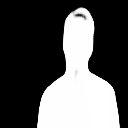

Epoch : 1961/2000
Model Loss(Batch: 0): [0.012200168333947659, 0.989414632320404]
Epoch : 1962/2000
Model Loss(Batch: 0): [0.012862621806561947, 0.9891435503959656]
Epoch : 1963/2000
Model Loss(Batch: 0): [0.013773752376437187, 0.9888231754302979]
Epoch : 1964/2000
Model Loss(Batch: 0): [0.01615235209465027, 0.987930178642273]
Epoch : 1965/2000
Model Loss(Batch: 0): [0.01830003596842289, 0.9872621893882751]
Epoch : 1966/2000
Model Loss(Batch: 0): [0.024168822914361954, 0.9853408336639404]
Epoch : 1967/2000
Model Loss(Batch: 0): [0.02189539186656475, 0.9862258434295654]
Epoch : 1968/2000
Model Loss(Batch: 0): [0.01859894208610058, 0.987061619758606]
Epoch : 1969/2000
Model Loss(Batch: 0): [0.01282754447311163, 0.9892104864120483]
Epoch : 1970/2000
Model Loss(Batch: 0): [0.01563313603401184, 0.988196849822998]


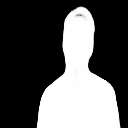

Epoch : 1971/2000
Model Loss(Batch: 0): [0.016923362389206886, 0.9876002073287964]
Epoch : 1972/2000
Model Loss(Batch: 0): [0.014011368155479431, 0.988766610622406]
Epoch : 1973/2000
Model Loss(Batch: 0): [0.014818878844380379, 0.988471508026123]
Epoch : 1974/2000
Model Loss(Batch: 0): [0.014016943983733654, 0.9887341856956482]
Epoch : 1975/2000
Model Loss(Batch: 0): [0.01453399658203125, 0.9885268807411194]
Epoch : 1976/2000
Model Loss(Batch: 0): [0.013402346521615982, 0.9890010356903076]
Epoch : 1977/2000
Model Loss(Batch: 0): [0.01349736750125885, 0.9889669418334961]
Epoch : 1978/2000
Model Loss(Batch: 0): [0.01363795530050993, 0.9888972640037537]
Epoch : 1979/2000
Model Loss(Batch: 0): [0.012830923311412334, 0.9892342686653137]
Epoch : 1980/2000
Model Loss(Batch: 0): [0.013177844695746899, 0.9890910983085632]


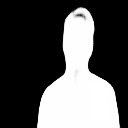

Epoch : 1981/2000
Model Loss(Batch: 0): [0.012896408326923847, 0.9892539978027344]
Epoch : 1982/2000
Model Loss(Batch: 0): [0.012705403380095959, 0.9892858266830444]
Epoch : 1983/2000
Model Loss(Batch: 0): [0.012656068429350853, 0.9893110394477844]
Epoch : 1984/2000
Model Loss(Batch: 0): [0.012612741440534592, 0.9893405437469482]
Epoch : 1985/2000
Model Loss(Batch: 0): [0.012411520816385746, 0.9894209504127502]
Epoch : 1986/2000
Model Loss(Batch: 0): [0.012357381172478199, 0.9894173741340637]
Epoch : 1987/2000
Model Loss(Batch: 0): [0.012383315712213516, 0.9894137382507324]
Epoch : 1988/2000
Model Loss(Batch: 0): [0.012125588953495026, 0.9895301461219788]
Epoch : 1989/2000
Model Loss(Batch: 0): [0.012168491259217262, 0.9894962906837463]
Epoch : 1990/2000
Model Loss(Batch: 0): [0.012095419690012932, 0.9895066022872925]


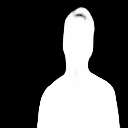

Epoch : 1991/2000
Model Loss(Batch: 0): [0.012007324025034904, 0.9895448684692383]
Epoch : 1992/2000
Model Loss(Batch: 0): [0.011932319030165672, 0.989573061466217]
Epoch : 1993/2000
Model Loss(Batch: 0): [0.011903872713446617, 0.9895627498626709]
Epoch : 1994/2000
Model Loss(Batch: 0): [0.011891593225300312, 0.9895550012588501]
Epoch : 1995/2000
Model Loss(Batch: 0): [0.01176172774285078, 0.9896065592765808]
Epoch : 1996/2000
Model Loss(Batch: 0): [0.011755426414310932, 0.989608645439148]
Epoch : 1997/2000
Model Loss(Batch: 0): [0.011714973486959934, 0.989613950252533]
Epoch : 1998/2000
Model Loss(Batch: 0): [0.011709180660545826, 0.989616870880127]
Epoch : 1999/2000
Model Loss(Batch: 0): [0.01163532305508852, 0.9896366596221924]
Epoch : 2000/2000
Model Loss(Batch: 0): [0.01157968770712614, 0.989653468132019]


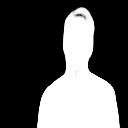

In [ ]:
EPOCHS = 1000
BATCH_SIZE = 290
checkpoint_dir="/content/gdrive/My Drive/Human_Segmentation/training_checkpoints"
Continue_training_step_number=0
train_model(X_train,Y_train,n_epochs=EPOCHS,batch_size=BATCH_SIZE,weights=Continue_training_step_number,checkpoint=checkpoint_dir)


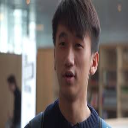

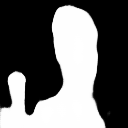

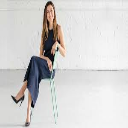

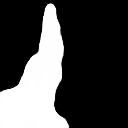

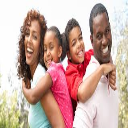

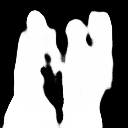

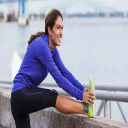

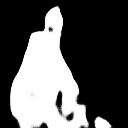

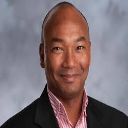

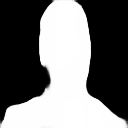

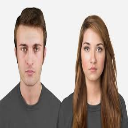

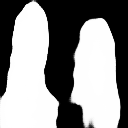

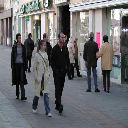

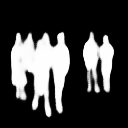

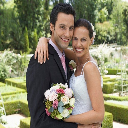

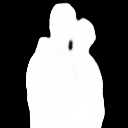

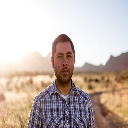

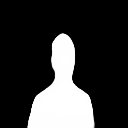

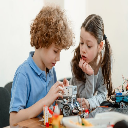

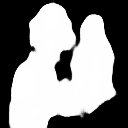

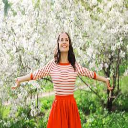

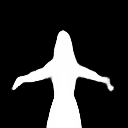

In [116]:
model = model_()
last_checkpoint_number=1000
model.load_weights(checkpoint_dir+'/mask_'+str(last_checkpoint_number)+'.h5')
inputs=[]
inputs_list= os.listdir(data_root+"/test")
for i in (inputs_list):
    img=cv2.imread(data_root+"/test/"+i)
    img=cv2.resize(img,(128,128))
    img = np.asarray(img)
    img = (img.astype(np.float32)-127.5)/127.5
    inputs.append(img)
inputs = np.array(inputs)
output=model.predict(inputs)
for i in range(len(inputs)):
  cv2_imshow(inputs[i]*127.5+127.5)
  cv2_imshow(output[i]*255)
  cv2.imwrite("/content/gdrive/My Drive/Human_Segmentation/test_out/img_in_"+str(i+1)+".jpg",inputs[i]*127.5+127.5)
  cv2.imwrite("/content/gdrive/My Drive/Human_Segmentation/test_out/img_out_"+str(i+1)+".jpg",output[i]*255)
